##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training and evaluation with the built-in methods

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/train_and_evaluate"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/training_with_built_in_methods.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/keras/train_and_evaluate.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Introduction

This guide covers training, evaluation, and prediction (inference) models
when using built-in APIs for training & validation (such as `Model.fit()`,
`Model.evaluate()` and `Model.predict()`).

If you are interested in leveraging `fit()` while specifying your
own training step function, see the
[Customizing what happens in `fit()` guide](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/).

If you are interested in writing your own training & evaluation loops from
scratch, see the guide
["writing a training loop from scratch"](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/).

In general, whether you are using built-in loops or writing your own, model training &
evaluation works strictly in the same way across every kind of Keras model --
Sequential models, models built with the Functional API, and models written from
scratch via model subclassing.

This guide doesn't cover distributed training, which is covered in our
[guide to multi-GPU & distributed training](https://keras.io/guides/distributed_training/).

## API overview: a first end-to-end example

When passing data to the built-in training loops of a model, you should either use
**NumPy arrays** (if your data is small and fits in memory) or **`tf.data Dataset`
objects**. In the next few paragraphs, we'll use the MNIST dataset as NumPy arrays, in
order to demonstrate how to use optimizers, losses, and metrics.

Let's consider the following model (here, we build in with the Functional API, but it
could be a Sequential model or a subclassed model as well):

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Here's what the typical end-to-end workflow looks like, consisting of:

- Training
- Validation on a holdout set generated from the original training data
- Evaluation on the test data

We'll use MNIST data for this example.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

    8192/11490434 [..............................] - ETA: 0s

 5529600/11490434 [=============>................] - ETA: 0s

11149312/11490434 [============================>.] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


We specify the training configuration (optimizer, loss, metrics):

In [5]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

We call `fit()`, which will train the model by slicing the data into "batches" of size
`batch_size`, and repeatedly iterating over the entire dataset for a given number of
`epochs`.

In [6]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2


  1/782 [..............................] - ETA: 9:16 - loss: 2.3115 - sparse_categorical_accuracy: 0.1406

 27/782 [>.............................] - ETA: 1s - loss: 1.9183 - sparse_categorical_accuracy: 0.4095  

 53/782 [=>............................] - ETA: 1s - loss: 1.6239 - sparse_categorical_accuracy: 0.5268

 79/782 [==>...........................] - ETA: 1s - loss: 1.4317 - sparse_categorical_accuracy: 0.5913

105/782 [===>..........................] - ETA: 1s - loss: 1.2975 - sparse_categorical_accuracy: 0.6338

131/782 [====>.........................] - ETA: 1s - loss: 1.1971 - sparse_categorical_accuracy: 0.6642

157/782 [=====>........................] - ETA: 1s - loss: 1.1175 - sparse_categorical_accuracy: 0.6876

183/782 [======>.......................] - ETA: 1s - loss: 1.0521 - sparse_categorical_accuracy: 0.7065

209/782 [=======>......................] - ETA: 1s - loss: 0.9973 - sparse_categorical_accuracy: 0.7221

235/782 [========>.....................] - ETA: 1s - loss: 0.9510 - sparse_categorical_accuracy: 0.7353

261/782 [=========>....................] - ETA: 1s - loss: 0.9112 - sparse_categorical_accuracy: 0.7465

288/782 [==========>...................] - ETA: 0s - loss: 0.8752 - sparse_categorical_accuracy: 0.7566

315/782 [===========>..................] - ETA: 0s - loss: 0.8436 - sparse_categorical_accuracy: 0.7655

341/782 [============>.................] - ETA: 0s - loss: 0.8166 - sparse_categorical_accuracy: 0.7730

367/782 [=============>................] - ETA: 0s - loss: 0.7922 - sparse_categorical_accuracy: 0.7797

393/782 [==============>...............] - ETA: 0s - loss: 0.7700 - sparse_categorical_accuracy: 0.7859

418/782 [===============>..............] - ETA: 0s - loss: 0.7506 - sparse_categorical_accuracy: 0.7912

443/782 [===============>..............] - ETA: 0s - loss: 0.7327 - sparse_categorical_accuracy: 0.7961

469/782 [================>.............] - ETA: 0s - loss: 0.7156 - sparse_categorical_accuracy: 0.8008

495/782 [=================>............] - ETA: 0s - loss: 0.6998 - sparse_categorical_accuracy: 0.8051

522/782 [===================>..........] - ETA: 0s - loss: 0.6844 - sparse_categorical_accuracy: 0.8093

548/782 [====================>.........] - ETA: 0s - loss: 0.6706 - sparse_categorical_accuracy: 0.8131

574/782 [=====================>........] - ETA: 0s - loss: 0.6577 - sparse_categorical_accuracy: 0.8166

600/782 [======================>.......] - ETA: 0s - loss: 0.6456 - sparse_categorical_accuracy: 0.8199

627/782 [=======================>......] - ETA: 0s - loss: 0.6338 - sparse_categorical_accuracy: 0.8231

654/782 [========================>.....] - ETA: 0s - loss: 0.6226 - sparse_categorical_accuracy: 0.8262

680/782 [=========================>....] - ETA: 0s - loss: 0.6125 - sparse_categorical_accuracy: 0.8289

706/782 [==========================>...] - ETA: 0s - loss: 0.6028 - sparse_categorical_accuracy: 0.8316

733/782 [===========================>..] - ETA: 0s - loss: 0.5933 - sparse_categorical_accuracy: 0.8341

759/782 [============================>.] - ETA: 0s - loss: 0.5846 - sparse_categorical_accuracy: 0.8365

782/782 [==============================] - 3s 3ms/step - loss: 0.5769 - sparse_categorical_accuracy: 0.8386 - val_loss: 0.1833 - val_sparse_categorical_accuracy: 0.9464


Epoch 2/2
  1/782 [..............................] - ETA: 1s - loss: 0.2999 - sparse_categorical_accuracy: 0.9375

 28/782 [>.............................] - ETA: 1s - loss: 0.1733 - sparse_categorical_accuracy: 0.9482

 54/782 [=>............................] - ETA: 1s - loss: 0.1696 - sparse_categorical_accuracy: 0.9491

 80/782 [==>...........................] - ETA: 1s - loss: 0.1686 - sparse_categorical_accuracy: 0.9502

106/782 [===>..........................] - ETA: 1s - loss: 0.1691 - sparse_categorical_accuracy: 0.9508

132/782 [====>.........................] - ETA: 1s - loss: 0.1690 - sparse_categorical_accuracy: 0.9510

158/782 [=====>........................] - ETA: 1s - loss: 0.1688 - sparse_categorical_accuracy: 0.9510

184/782 [======>.......................] - ETA: 1s - loss: 0.1683 - sparse_categorical_accuracy: 0.9511

210/782 [=======>......................] - ETA: 1s - loss: 0.1679 - sparse_categorical_accuracy: 0.9512

237/782 [========>.....................] - ETA: 1s - loss: 0.1676 - sparse_categorical_accuracy: 0.9511

264/782 [=========>....................] - ETA: 1s - loss: 0.1674 - sparse_categorical_accuracy: 0.9511

291/782 [==========>...................] - ETA: 0s - loss: 0.1673 - sparse_categorical_accuracy: 0.9510

317/782 [===========>..................] - ETA: 0s - loss: 0.1672 - sparse_categorical_accuracy: 0.9510

343/782 [============>.................] - ETA: 0s - loss: 0.1671 - sparse_categorical_accuracy: 0.9509

369/782 [=============>................] - ETA: 0s - loss: 0.1669 - sparse_categorical_accuracy: 0.9509

395/782 [==============>...............] - ETA: 0s - loss: 0.1668 - sparse_categorical_accuracy: 0.9509

422/782 [===============>..............] - ETA: 0s - loss: 0.1665 - sparse_categorical_accuracy: 0.9509

448/782 [================>.............] - ETA: 0s - loss: 0.1662 - sparse_categorical_accuracy: 0.9509

474/782 [=================>............] - ETA: 0s - loss: 0.1659 - sparse_categorical_accuracy: 0.9510

500/782 [==================>...........] - ETA: 0s - loss: 0.1657 - sparse_categorical_accuracy: 0.9511

527/782 [===================>..........] - ETA: 0s - loss: 0.1654 - sparse_categorical_accuracy: 0.9511

554/782 [====================>.........] - ETA: 0s - loss: 0.1651 - sparse_categorical_accuracy: 0.9512

580/782 [=====================>........] - ETA: 0s - loss: 0.1648 - sparse_categorical_accuracy: 0.9512

606/782 [======================>.......] - ETA: 0s - loss: 0.1645 - sparse_categorical_accuracy: 0.9513

632/782 [=======================>......] - ETA: 0s - loss: 0.1641 - sparse_categorical_accuracy: 0.9514

659/782 [========================>.....] - ETA: 0s - loss: 0.1638 - sparse_categorical_accuracy: 0.9514

685/782 [=========================>....] - ETA: 0s - loss: 0.1634 - sparse_categorical_accuracy: 0.9515

712/782 [==========================>...] - ETA: 0s - loss: 0.1630 - sparse_categorical_accuracy: 0.9516

738/782 [===========================>..] - ETA: 0s - loss: 0.1627 - sparse_categorical_accuracy: 0.9517

764/782 [============================>.] - ETA: 0s - loss: 0.1624 - sparse_categorical_accuracy: 0.9517

782/782 [==============================] - 2s 2ms/step - loss: 0.1621 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.1467 - val_sparse_categorical_accuracy: 0.9579


The returned `history` object holds a record of the loss values and metric values
during training:

In [7]:
history.history

{'loss': [0.3323673903942108, 0.15159013867378235],
 'sparse_categorical_accuracy': [0.9050800204277039, 0.9542400240898132],
 'val_loss': [0.18328842520713806, 0.14667865633964539],
 'val_sparse_categorical_accuracy': [0.946399986743927, 0.9578999876976013]}

We evaluate the model on the test data via `evaluate()`:

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
 1/79 [..............................] - ETA: 1s - loss: 0.0636 - sparse_categorical_accuracy: 0.9766

34/79 [===========>..................] - ETA: 0s - loss: 0.1831 - sparse_categorical_accuracy: 0.9412

67/79 [========================>.....] - ETA: 0s - loss: 0.1511 - sparse_categorical_accuracy: 0.9516

79/79 [==============================] - 0s 2ms/step - loss: 0.1449 - sparse_categorical_accuracy: 0.9539


test loss, test acc: [0.14493884146213531, 0.9538999795913696]
Generate predictions for 3 samples


predictions shape: (3, 10)


Now, let's review each piece of this workflow in detail.

## The `compile()` method: specifying a loss, metrics, and an optimizer

To train a model with `fit()`, you need to specify a loss function, an optimizer, and
optionally, some metrics to monitor.

You pass these to the model as arguments to the `compile()` method:

In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

The `metrics` argument should be a list -- your model can have any number of metrics.

If your model has multiple outputs, you can specify different losses and metrics for
each output, and you can modulate the contribution of each output to the total loss of
the model. You will find more details about this in the **Passing data to multi-input,
multi-output models** section.

Note that if you're satisfied with the default settings, in many cases the optimizer,
loss, and metrics can be specified via string identifiers as a shortcut:

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

For later reuse, let's put our model definition and compile step in functions; we will
call them several times across different examples in this guide.

In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### Many built-in optimizers, losses, and metrics are available

In general, you won't have to create your own losses, metrics, or optimizers
from scratch, because what you need is likely to be already part of the Keras API:

Optimizers:

- `SGD()` (with or without momentum)
- `RMSprop()`
- `Adam()`
- etc.

Losses:

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- etc.

Metrics:

- `AUC()`
- `Precision()`
- `Recall()`
- etc.

### Custom losses

If you need to create a custom loss, Keras provides two ways to do so.

The first method involves creating a function that accepts inputs `y_true` and
`y_pred`. The following example shows a loss function that computes the mean squared
error between the real data and the predictions:

In [12]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 3:09 - loss: 0.0899

 35/782 [>.............................] - ETA: 1s - loss: 0.0799  

 70/782 [=>............................] - ETA: 1s - loss: 0.0691

105/782 [===>..........................] - ETA: 0s - loss: 0.0610

140/782 [====>.........................] - ETA: 0s - loss: 0.0550

175/782 [=====>........................] - ETA: 0s - loss: 0.0505

210/782 [=======>......................] - ETA: 0s - loss: 0.0470

244/782 [========>.....................] - ETA: 0s - loss: 0.0442

277/782 [=========>....................] - ETA: 0s - loss: 0.0420

311/782 [==========>...................] - ETA: 0s - loss: 0.0400

347/782 [============>.................] - ETA: 0s - loss: 0.0382

382/782 [=============>................] - ETA: 0s - loss: 0.0367

418/782 [===============>..............] - ETA: 0s - loss: 0.0353

453/782 [================>.............] - ETA: 0s - loss: 0.0342

488/782 [=================>............] - ETA: 0s - loss: 0.0331

524/782 [===================>..........] - ETA: 0s - loss: 0.0321

560/782 [====================>.........] - ETA: 0s - loss: 0.0313

596/782 [=====================>........] - ETA: 0s - loss: 0.0305

631/782 [=======================>......] - ETA: 0s - loss: 0.0297

667/782 [========================>.....] - ETA: 0s - loss: 0.0290

703/782 [=========================>....] - ETA: 0s - loss: 0.0284

739/782 [===========================>..] - ETA: 0s - loss: 0.0278

774/782 [============================>.] - ETA: 0s - loss: 0.0273

782/782 [==============================] - 1s 1ms/step - loss: 0.0272


If you need a loss function that takes in parameters beside `y_true` and `y_pred`, you
can subclass the `tf.keras.losses.Loss` class and implement the following two methods:

- `__init__(self)`: accept parameters to pass during the call of your loss function
- `call(self, y_true, y_pred)`: use the targets (y_true) and the model predictions
(y_pred) to compute the model's loss

Let's say you want to use mean squared error, but with an added term that
will de-incentivize  prediction values far from 0.5 (we assume that the categorical
targets are one-hot encoded and take values between 0 and 1). This
creates an incentive for the model not to be too confident, which may help
reduce overfitting (we won't know if it works until we try!).

Here's how you would do it:

In [13]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 3:48 - loss: 0.1074

 31/782 [>.............................] - ETA: 1s - loss: 0.0992  

 61/782 [=>............................] - ETA: 1s - loss: 0.0898

 92/782 [==>...........................] - ETA: 1s - loss: 0.0821

123/782 [===>..........................] - ETA: 1s - loss: 0.0765

154/782 [====>.........................] - ETA: 1s - loss: 0.0723

185/782 [======>.......................] - ETA: 0s - loss: 0.0690

216/782 [=======>......................] - ETA: 0s - loss: 0.0663

247/782 [========>.....................] - ETA: 0s - loss: 0.0640

278/782 [=========>....................] - ETA: 0s - loss: 0.0622

309/782 [==========>...................] - ETA: 0s - loss: 0.0606

340/782 [============>.................] - ETA: 0s - loss: 0.0591

371/782 [=============>................] - ETA: 0s - loss: 0.0579

402/782 [==============>...............] - ETA: 0s - loss: 0.0568

433/782 [===============>..............] - ETA: 0s - loss: 0.0558

464/782 [================>.............] - ETA: 0s - loss: 0.0549

495/782 [=================>............] - ETA: 0s - loss: 0.0541

527/782 [===================>..........] - ETA: 0s - loss: 0.0533

558/782 [====================>.........] - ETA: 0s - loss: 0.0526

589/782 [=====================>........] - ETA: 0s - loss: 0.0520

620/782 [======================>.......] - ETA: 0s - loss: 0.0514

651/782 [=======================>......] - ETA: 0s - loss: 0.0509

681/782 [=========================>....] - ETA: 0s - loss: 0.0504

712/782 [==========================>...] - ETA: 0s - loss: 0.0499

744/782 [===========================>..] - ETA: 0s - loss: 0.0495

775/782 [============================>.] - ETA: 0s - loss: 0.0490

782/782 [==============================] - 2s 2ms/step - loss: 0.0489


### Custom metrics

If you need a metric that isn't part of the API, you can easily create custom metrics
by subclassing the `tf.keras.metrics.Metric` class. You will need to implement 4
methods:

- `__init__(self)`, in which you will create state variables for your metric.
- `update_state(self, y_true, y_pred, sample_weight=None)`, which uses the targets
y_true and the model predictions y_pred to update the state variables.
- `result(self)`, which uses the state variables to compute the final results.
- `reset_states(self)`, which reinitializes the state of the metric.

State update and results computation are kept separate (in `update_state()` and
`result()`, respectively) because in some cases, the results computation might be very
expensive and would only be done periodically.

Here's a simple example showing how to implement a `CategoricalTruePositives` metric
that counts how many samples were correctly classified as belonging to a given class:

In [14]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3


  1/782 [..............................] - ETA: 6:17 - loss: 2.3360 - categorical_true_positives: 7.0000

 26/782 [..............................] - ETA: 1s - loss: 1.9209 - categorical_true_positives: 435.1923

 52/782 [>.............................] - ETA: 1s - loss: 1.6241 - categorical_true_positives: 1061.8077

 77/782 [=>............................] - ETA: 1s - loss: 1.4356 - categorical_true_positives: 1707.5974

102/782 [==>...........................] - ETA: 1s - loss: 1.3023 - categorical_true_positives: 2372.2157

128/782 [===>..........................] - ETA: 1s - loss: 1.1971 - categorical_true_positives: 3080.9297

153/782 [====>.........................] - ETA: 1s - loss: 1.1180 - categorical_true_positives: 3773.4248

178/782 [=====>........................] - ETA: 1s - loss: 1.0539 - categorical_true_positives: 4472.9944

203/782 [======>.......................] - ETA: 1s - loss: 1.0007 - categorical_true_positives: 5177.8030

228/782 [=======>......................] - ETA: 1s - loss: 0.9553 - categorical_true_positives: 5887.1272

253/782 [========>.....................] - ETA: 1s - loss: 0.9161 - categorical_true_positives: 6599.9447

279/782 [=========>....................] - ETA: 1s - loss: 0.8804 - categorical_true_positives: 7344.9140

304/782 [==========>...................] - ETA: 0s - loss: 0.8505 - categorical_true_positives: 8062.2303

330/782 [===========>..................] - ETA: 0s - loss: 0.8228 - categorical_true_positives: 8810.7879

355/782 [============>.................] - ETA: 0s - loss: 0.7990 - categorical_true_positives: 9531.9070

381/782 [=============>................] - ETA: 0s - loss: 0.7765 - categorical_true_positives: 10283.8766

407/782 [==============>...............] - ETA: 0s - loss: 0.7560 - categorical_true_positives: 11038.0319

432/782 [===============>..............] - ETA: 0s - loss: 0.7379 - categorical_true_positives: 11765.3148

456/782 [================>.............] - ETA: 0s - loss: 0.7219 - categorical_true_positives: 12464.9781

480/782 [=================>............] - ETA: 0s - loss: 0.7070 - categorical_true_positives: 13166.4042

505/782 [==================>...........] - ETA: 0s - loss: 0.6925 - categorical_true_positives: 13898.8535

531/782 [===================>..........] - ETA: 0s - loss: 0.6783 - categorical_true_positives: 14662.7589

556/782 [====================>.........] - ETA: 0s - loss: 0.6656 - categorical_true_positives: 15398.3705

582/782 [=====================>........] - ETA: 0s - loss: 0.6532 - categorical_true_positives: 16164.3643

608/782 [======================>.......] - ETA: 0s - loss: 0.6415 - categorical_true_positives: 16931.2418

633/782 [=======================>......] - ETA: 0s - loss: 0.6310 - categorical_true_positives: 17668.9147

659/782 [========================>.....] - ETA: 0s - loss: 0.6206 - categorical_true_positives: 18436.9484

685/782 [=========================>....] - ETA: 0s - loss: 0.6108 - categorical_true_positives: 19205.8131

710/782 [==========================>...] - ETA: 0s - loss: 0.6019 - categorical_true_positives: 19945.7521

735/782 [===========================>..] - ETA: 0s - loss: 0.5934 - categorical_true_positives: 20686.5211

761/782 [============================>.] - ETA: 0s - loss: 0.5850 - categorical_true_positives: 21457.8883

782/782 [==============================] - 2s 2ms/step - loss: 0.5782 - categorical_true_positives: 22110.9323


Epoch 2/3
  1/782 [..............................] - ETA: 1s - loss: 0.1275 - categorical_true_positives: 62.0000

 25/782 [..............................] - ETA: 1s - loss: 0.1944 - categorical_true_positives: 792.3600

 50/782 [>.............................] - ETA: 1s - loss: 0.1902 - categorical_true_positives: 1548.0400

 75/782 [=>............................] - ETA: 1s - loss: 0.1869 - categorical_true_positives: 2304.4267

101/782 [==>...........................] - ETA: 1s - loss: 0.1856 - categorical_true_positives: 3090.0891

126/782 [===>..........................] - ETA: 1s - loss: 0.1856 - categorical_true_positives: 3846.5873

152/782 [====>.........................] - ETA: 1s - loss: 0.1851 - categorical_true_positives: 4635.2237

178/782 [=====>........................] - ETA: 1s - loss: 0.1845 - categorical_true_positives: 5422.8708

204/782 [======>.......................] - ETA: 1s - loss: 0.1840 - categorical_true_positives: 6210.4510

230/782 [=======>......................] - ETA: 1s - loss: 0.1835 - categorical_true_positives: 6998.1217

256/782 [========>.....................] - ETA: 1s - loss: 0.1830 - categorical_true_positives: 7785.3242

282/782 [=========>....................] - ETA: 0s - loss: 0.1826 - categorical_true_positives: 8572.5532

308/782 [==========>...................] - ETA: 0s - loss: 0.1820 - categorical_true_positives: 9360.7435

334/782 [===========>..................] - ETA: 0s - loss: 0.1815 - categorical_true_positives: 10149.5569

360/782 [============>.................] - ETA: 0s - loss: 0.1809 - categorical_true_positives: 10938.9583

386/782 [=============>................] - ETA: 0s - loss: 0.1804 - categorical_true_positives: 11728.1528

411/782 [==============>...............] - ETA: 0s - loss: 0.1800 - categorical_true_positives: 12486.9392

437/782 [===============>..............] - ETA: 0s - loss: 0.1795 - categorical_true_positives: 13277.0847

462/782 [================>.............] - ETA: 0s - loss: 0.1791 - categorical_true_positives: 14037.5195

487/782 [=================>............] - ETA: 0s - loss: 0.1786 - categorical_true_positives: 14798.5257

512/782 [==================>...........] - ETA: 0s - loss: 0.1781 - categorical_true_positives: 15560.1816

537/782 [===================>..........] - ETA: 0s - loss: 0.1777 - categorical_true_positives: 16322.1546

562/782 [====================>.........] - ETA: 0s - loss: 0.1772 - categorical_true_positives: 17084.3114

588/782 [=====================>........] - ETA: 0s - loss: 0.1768 - categorical_true_positives: 17877.1344

613/782 [======================>.......] - ETA: 0s - loss: 0.1764 - categorical_true_positives: 18639.5220

638/782 [=======================>......] - ETA: 0s - loss: 0.1759 - categorical_true_positives: 19401.8981

663/782 [========================>.....] - ETA: 0s - loss: 0.1755 - categorical_true_positives: 20164.0332

688/782 [=========================>....] - ETA: 0s - loss: 0.1752 - categorical_true_positives: 20926.2587

714/782 [==========================>...] - ETA: 0s - loss: 0.1748 - categorical_true_positives: 21719.5042

740/782 [===========================>..] - ETA: 0s - loss: 0.1744 - categorical_true_positives: 22512.9514

765/782 [============================>.] - ETA: 0s - loss: 0.1740 - categorical_true_positives: 23276.2627

782/782 [==============================] - 2s 2ms/step - loss: 0.1737 - categorical_true_positives: 23825.8212


Epoch 3/3
  1/782 [..............................] - ETA: 1s - loss: 0.1788 - categorical_true_positives: 62.0000

 27/782 [>.............................] - ETA: 1s - loss: 0.1401 - categorical_true_positives: 854.6667

 53/782 [=>............................] - ETA: 1s - loss: 0.1327 - categorical_true_positives: 1654.7925

 78/782 [=>............................] - ETA: 1s - loss: 0.1315 - categorical_true_positives: 2424.5897

104/782 [==>...........................] - ETA: 1s - loss: 0.1318 - categorical_true_positives: 3223.4327

130/782 [===>..........................] - ETA: 1s - loss: 0.1316 - categorical_true_positives: 4022.4846

156/782 [====>.........................] - ETA: 1s - loss: 0.1313 - categorical_true_positives: 4823.0449

181/782 [=====>........................] - ETA: 1s - loss: 0.1309 - categorical_true_positives: 5592.6243

207/782 [======>.......................] - ETA: 1s - loss: 0.1306 - categorical_true_positives: 6392.6232

233/782 [=======>......................] - ETA: 1s - loss: 0.1306 - categorical_true_positives: 7190.8197

258/782 [========>.....................] - ETA: 1s - loss: 0.1305 - categorical_true_positives: 7959.4070

284/782 [=========>....................] - ETA: 0s - loss: 0.1303 - categorical_true_positives: 8759.7148

310/782 [==========>...................] - ETA: 0s - loss: 0.1301 - categorical_true_positives: 9560.2226

336/782 [===========>..................] - ETA: 0s - loss: 0.1299 - categorical_true_positives: 10361.2232

361/782 [============>.................] - ETA: 0s - loss: 0.1296 - categorical_true_positives: 11131.6399

387/782 [=============>................] - ETA: 0s - loss: 0.1292 - categorical_true_positives: 11932.6873

413/782 [==============>...............] - ETA: 0s - loss: 0.1290 - categorical_true_positives: 12733.8668

438/782 [===============>..............] - ETA: 0s - loss: 0.1287 - categorical_true_positives: 13504.6438

463/782 [================>.............] - ETA: 0s - loss: 0.1284 - categorical_true_positives: 14276.1469

489/782 [=================>............] - ETA: 0s - loss: 0.1281 - categorical_true_positives: 15078.7914

515/782 [==================>...........] - ETA: 0s - loss: 0.1279 - categorical_true_positives: 15881.2835

541/782 [===================>..........] - ETA: 0s - loss: 0.1276 - categorical_true_positives: 16683.7560

567/782 [====================>.........] - ETA: 0s - loss: 0.1273 - categorical_true_positives: 17486.0988

592/782 [=====================>........] - ETA: 0s - loss: 0.1271 - categorical_true_positives: 18257.8074

618/782 [======================>.......] - ETA: 0s - loss: 0.1268 - categorical_true_positives: 19060.4256

644/782 [=======================>......] - ETA: 0s - loss: 0.1265 - categorical_true_positives: 19862.8354

670/782 [========================>.....] - ETA: 0s - loss: 0.1263 - categorical_true_positives: 20665.1164

696/782 [=========================>....] - ETA: 0s - loss: 0.1261 - categorical_true_positives: 21467.1810

722/782 [==========================>...] - ETA: 0s - loss: 0.1259 - categorical_true_positives: 22269.4280

747/782 [===========================>..] - ETA: 0s - loss: 0.1257 - categorical_true_positives: 23040.9786

772/782 [============================>.] - ETA: 0s - loss: 0.1255 - categorical_true_positives: 23812.9508

782/782 [==============================] - 2s 2ms/step - loss: 0.1254 - categorical_true_positives: 24152.4547


### Handling losses and metrics that don't fit the standard signature

The overwhelming majority of losses and metrics can be computed from `y_true` and
`y_pred`, where `y_pred` is an output of your model -- but not all of them. For
instance, a regularization loss may only require the activation of a layer (there are
no targets in this case), and this activation may not be a model output.

In such cases, you can call `self.add_loss(loss_value)` from inside the call method of
a custom layer. Losses added in this way get added to the "main" loss during training
(the one passed to `compile()`). Here's a simple example that adds activity
regularization (note that activity regularization is built-in in all Keras layers --
this layer is just for the sake of providing a concrete example):

In [15]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 3:54 - loss: 69.9497

 29/782 [>.............................] - ETA: 1s - loss: 16.5065  

 59/782 [=>............................] - ETA: 1s - loss: 10.9283

 88/782 [==>...........................] - ETA: 1s - loss: 8.7159 

116/782 [===>..........................] - ETA: 1s - loss: 7.4995

146/782 [====>.........................] - ETA: 1s - loss: 6.6516

175/782 [=====>........................] - ETA: 1s - loss: 6.0755

203/782 [======>.......................] - ETA: 1s - loss: 5.6575

231/782 [=======>......................] - ETA: 0s - loss: 5.3292

259/782 [========>.....................] - ETA: 0s - loss: 5.0639

287/782 [==========>...................] - ETA: 0s - loss: 4.8446

316/782 [===========>..................] - ETA: 0s - loss: 4.6540

345/782 [============>.................] - ETA: 0s - loss: 4.4920

374/782 [=============>................] - ETA: 0s - loss: 4.3525

403/782 [==============>...............] - ETA: 0s - loss: 4.2310

433/782 [===============>..............] - ETA: 0s - loss: 4.1206

463/782 [================>.............] - ETA: 0s - loss: 4.0231

492/782 [=================>............] - ETA: 0s - loss: 3.9390

519/782 [==================>...........] - ETA: 0s - loss: 3.8683

547/782 [===================>..........] - ETA: 0s - loss: 3.8016

575/782 [=====================>........] - ETA: 0s - loss: 3.7408

604/782 [======================>.......] - ETA: 0s - loss: 3.6831

633/782 [=======================>......] - ETA: 0s - loss: 3.6303

662/782 [========================>.....] - ETA: 0s - loss: 3.5816

691/782 [=========================>....] - ETA: 0s - loss: 3.5366

720/782 [==========================>...] - ETA: 0s - loss: 3.4949

749/782 [===========================>..] - ETA: 0s - loss: 3.4561

778/782 [============================>.] - ETA: 0s - loss: 3.4199

782/782 [==============================] - 2s 2ms/step - loss: 3.4140


You can do the same for logging metric values, using `add_metric()`:

In [16]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 4:05 - loss: 2.3326 - std_of_activation: 0.2756

 26/782 [..............................] - ETA: 1s - loss: 1.8442 - std_of_activation: 0.4610  

 52/782 [>.............................] - ETA: 1s - loss: 1.5625 - std_of_activation: 0.5872

 79/782 [==>...........................] - ETA: 1s - loss: 1.3770 - std_of_activation: 0.6669

106/782 [===>..........................] - ETA: 1s - loss: 1.2464 - std_of_activation: 0.7243

133/782 [====>.........................] - ETA: 1s - loss: 1.1483 - std_of_activation: 0.7669

160/782 [=====>........................] - ETA: 1s - loss: 1.0723 - std_of_activation: 0.7986

187/782 [======>.......................] - ETA: 1s - loss: 1.0100 - std_of_activation: 0.8213

214/782 [=======>......................] - ETA: 1s - loss: 0.9579 - std_of_activation: 0.8416

241/782 [========>.....................] - ETA: 1s - loss: 0.9135 - std_of_activation: 0.8602

267/782 [=========>....................] - ETA: 0s - loss: 0.8763 - std_of_activation: 0.8757

293/782 [==========>...................] - ETA: 0s - loss: 0.8437 - std_of_activation: 0.8880

319/782 [===========>..................] - ETA: 0s - loss: 0.8151 - std_of_activation: 0.8978

346/782 [============>.................] - ETA: 0s - loss: 0.7886 - std_of_activation: 0.9064

373/782 [=============>................] - ETA: 0s - loss: 0.7649 - std_of_activation: 0.9138

399/782 [==============>...............] - ETA: 0s - loss: 0.7443 - std_of_activation: 0.9207

426/782 [===============>..............] - ETA: 0s - loss: 0.7246 - std_of_activation: 0.9273

453/782 [================>.............] - ETA: 0s - loss: 0.7067 - std_of_activation: 0.9326

480/782 [=================>............] - ETA: 0s - loss: 0.6902 - std_of_activation: 0.9382

506/782 [==================>...........] - ETA: 0s - loss: 0.6755 - std_of_activation: 0.9422

533/782 [===================>..........] - ETA: 0s - loss: 0.6613 - std_of_activation: 0.9471

559/782 [====================>.........] - ETA: 0s - loss: 0.6485 - std_of_activation: 0.9511

585/782 [=====================>........] - ETA: 0s - loss: 0.6365 - std_of_activation: 0.9550

612/782 [======================>.......] - ETA: 0s - loss: 0.6248 - std_of_activation: 0.9587

638/782 [=======================>......] - ETA: 0s - loss: 0.6141 - std_of_activation: 0.9611

664/782 [========================>.....] - ETA: 0s - loss: 0.6041 - std_of_activation: 0.9633

690/782 [=========================>....] - ETA: 0s - loss: 0.5946 - std_of_activation: 0.9654

717/782 [==========================>...] - ETA: 0s - loss: 0.5853 - std_of_activation: 0.9669

743/782 [===========================>..] - ETA: 0s - loss: 0.5769 - std_of_activation: 0.9681

769/782 [============================>.] - ETA: 0s - loss: 0.5688 - std_of_activation: 0.9694

782/782 [==============================] - 2s 2ms/step - loss: 0.5646 - std_of_activation: 0.9702


In the [Functional API](https://www.tensorflow.org/guide/keras/functional/),
you can also call `model.add_loss(loss_tensor)`,
or `model.add_metric(metric_tensor, name, aggregation)`.

Here's a simple example:

In [17]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 4:21 - loss: 81.9705 - std_of_activation: 0.2789

 27/782 [>.............................] - ETA: 1s - loss: 19.9808 - std_of_activation: 0.0434  

 54/782 [=>............................] - ETA: 1s - loss: 13.2137 - std_of_activation: 0.0246

 80/782 [==>...........................] - ETA: 1s - loss: 10.4727 - std_of_activation: 0.0174

106/782 [===>..........................] - ETA: 1s - loss: 8.9059 - std_of_activation: 0.0134 

132/782 [====>.........................] - ETA: 1s - loss: 7.8797 - std_of_activation: 0.0109

158/782 [=====>........................] - ETA: 1s - loss: 7.1501 - std_of_activation: 0.0092

184/782 [======>.......................] - ETA: 1s - loss: 6.6021 - std_of_activation: 0.0080

210/782 [=======>......................] - ETA: 1s - loss: 6.1740 - std_of_activation: 0.0070

236/782 [========>.....................] - ETA: 1s - loss: 5.8294 - std_of_activation: 0.0063

262/782 [=========>....................] - ETA: 1s - loss: 5.5455 - std_of_activation: 0.0057

288/782 [==========>...................] - ETA: 0s - loss: 5.3072 - std_of_activation: 0.0052

314/782 [===========>..................] - ETA: 0s - loss: 5.1040 - std_of_activation: 0.0048

340/782 [============>.................] - ETA: 0s - loss: 4.9286 - std_of_activation: 0.0044

366/782 [=============>................] - ETA: 0s - loss: 4.7754 - std_of_activation: 0.0041

392/782 [==============>...............] - ETA: 0s - loss: 4.6404 - std_of_activation: 0.0038

418/782 [===============>..............] - ETA: 0s - loss: 4.5205 - std_of_activation: 0.0036

444/782 [================>.............] - ETA: 0s - loss: 4.4131 - std_of_activation: 0.0034

470/782 [=================>............] - ETA: 0s - loss: 4.3165 - std_of_activation: 0.0032

496/782 [==================>...........] - ETA: 0s - loss: 4.2289 - std_of_activation: 0.0031

522/782 [===================>..........] - ETA: 0s - loss: 4.1492 - std_of_activation: 0.0029

548/782 [====================>.........] - ETA: 0s - loss: 4.0763 - std_of_activation: 0.0028

574/782 [=====================>........] - ETA: 0s - loss: 4.0093 - std_of_activation: 0.0027

600/782 [======================>.......] - ETA: 0s - loss: 3.9476 - std_of_activation: 0.0026

626/782 [=======================>......] - ETA: 0s - loss: 3.8905 - std_of_activation: 0.0025

652/782 [========================>.....] - ETA: 0s - loss: 3.8375 - std_of_activation: 0.0024

678/782 [=========================>....] - ETA: 0s - loss: 3.7882 - std_of_activation: 0.0023

704/782 [==========================>...] - ETA: 0s - loss: 3.7422 - std_of_activation: 0.0022

730/782 [===========================>..] - ETA: 0s - loss: 3.6992 - std_of_activation: 0.0021

756/782 [============================>.] - ETA: 0s - loss: 3.6588 - std_of_activation: 0.0020

782/782 [==============================] - ETA: 0s - loss: 3.6209 - std_of_activation: 0.0020

782/782 [==============================] - 2s 2ms/step - loss: 3.6195 - std_of_activation: 0.0020


Note that when you pass losses via `add_loss()`, it becomes possible to call
`compile()` without a loss function, since the model already has a loss to minimize.

Consider the following `LogisticEndpoint` layer: it takes as inputs
targets & logits, and it tracks a crossentropy loss via `add_loss()`. It also
tracks classification accuracy via `add_metric()`.

In [18]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


You can use it in a model with two inputs (input data & targets), compiled without a
`loss` argument, like this:

In [19]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - ETA: 0s - loss: 0.9652 - binary_accuracy: 0.0000e+00

1/1 [==============================] - 0s 222ms/step - loss: 0.9652 - binary_accuracy: 0.0000e+00


For more information about training multi-input models, see the section **Passing data
to multi-input, multi-output models**.

### Automatically setting apart a validation holdout set

In the first end-to-end example you saw, we used the `validation_data` argument to pass
a tuple of NumPy arrays `(x_val, y_val)` to the model for evaluating a validation loss
and validation metrics at the end of each epoch.

Here's another option: the argument `validation_split` allows you to automatically
reserve part of your training data for validation. The argument value represents the
fraction of the data to be reserved for validation, so it should be set to a number
higher than 0 and lower than 1. For instance, `validation_split=0.2` means "use 20% of
the data for validation", and `validation_split=0.6` means "use 60% of the data for
validation".

The way the validation is computed is by taking the last x% samples of the arrays
received by the `fit()` call, before any shuffling.

Note that you can only use `validation_split` when training with NumPy data.

In [20]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

  1/625 [..............................] - ETA: 3:16 - loss: 2.3406 - sparse_categorical_accuracy: 0.0625

 30/625 [>.............................] - ETA: 1s - loss: 1.7595 - sparse_categorical_accuracy: 0.5189  

 59/625 [=>............................] - ETA: 0s - loss: 1.4661 - sparse_categorical_accuracy: 0.6189

 88/625 [===>..........................] - ETA: 0s - loss: 1.2876 - sparse_categorical_accuracy: 0.6694

117/625 [====>.........................] - ETA: 0s - loss: 1.1645 - sparse_categorical_accuracy: 0.7016

146/625 [======>.......................] - ETA: 0s - loss: 1.0743 - sparse_categorical_accuracy: 0.7246

176/625 [=======>......................] - ETA: 0s - loss: 1.0015 - sparse_categorical_accuracy: 0.7429

205/625 [========>.....................] - ETA: 0s - loss: 0.9449 - sparse_categorical_accuracy: 0.7569

235/625 [==========>...................] - ETA: 0s - loss: 0.8963 - sparse_categorical_accuracy: 0.7688

265/625 [===========>..................] - ETA: 0s - loss: 0.8549 - sparse_categorical_accuracy: 0.7788

295/625 [=============>................] - ETA: 0s - loss: 0.8195 - sparse_categorical_accuracy: 0.7874

324/625 [==============>...............] - ETA: 0s - loss: 0.7898 - sparse_categorical_accuracy: 0.7945

353/625 [===============>..............] - ETA: 0s - loss: 0.7634 - sparse_categorical_accuracy: 0.8009

382/625 [=================>............] - ETA: 0s - loss: 0.7399 - sparse_categorical_accuracy: 0.8066

411/625 [==================>...........] - ETA: 0s - loss: 0.7187 - sparse_categorical_accuracy: 0.8118

441/625 [====================>.........] - ETA: 0s - loss: 0.6987 - sparse_categorical_accuracy: 0.8166

470/625 [=====================>........] - ETA: 0s - loss: 0.6812 - sparse_categorical_accuracy: 0.8209

499/625 [======================>.......] - ETA: 0s - loss: 0.6650 - sparse_categorical_accuracy: 0.8248

529/625 [========================>.....] - ETA: 0s - loss: 0.6497 - sparse_categorical_accuracy: 0.8285

559/625 [=========================>....] - ETA: 0s - loss: 0.6356 - sparse_categorical_accuracy: 0.8320

589/625 [===========================>..] - ETA: 0s - loss: 0.6224 - sparse_categorical_accuracy: 0.8352

618/625 [============================>.] - ETA: 0s - loss: 0.6106 - sparse_categorical_accuracy: 0.8381

625/625 [==============================] - 2s 2ms/step - loss: 0.6075 - sparse_categorical_accuracy: 0.8389 - val_loss: 0.2291 - val_sparse_categorical_accuracy: 0.9322


## Training & evaluation from tf.data Datasets

In the past few paragraphs, you've seen how to handle losses, metrics, and optimizers,
and you've seen how to use the `validation_data` and `validation_split` arguments in
`fit()`, when your data is passed as NumPy arrays.

Let's now take a look at the case where your data comes in the form of a
`tf.data.Dataset` object.

The `tf.data` API is a set of utilities in TensorFlow 2.0 for loading and preprocessing
data in a way that's fast and scalable.

For a complete guide about creating `Datasets`, see the
[tf.data documentation](https://www.tensorflow.org/guide/data).

You can pass a `Dataset` instance directly to the methods `fit()`, `evaluate()`, and
`predict()`:

In [21]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3


  1/782 [..............................] - ETA: 4:09 - loss: 2.3403 - sparse_categorical_accuracy: 0.0625

 24/782 [..............................] - ETA: 1s - loss: 1.9017 - sparse_categorical_accuracy: 0.3766  

 47/782 [>.............................] - ETA: 1s - loss: 1.6200 - sparse_categorical_accuracy: 0.5004

 72/782 [=>............................] - ETA: 1s - loss: 1.4193 - sparse_categorical_accuracy: 0.5749

 96/782 [==>...........................] - ETA: 1s - loss: 1.2824 - sparse_categorical_accuracy: 0.6217

121/782 [===>..........................] - ETA: 1s - loss: 1.1759 - sparse_categorical_accuracy: 0.6567

145/782 [====>.........................] - ETA: 1s - loss: 1.0977 - sparse_categorical_accuracy: 0.6818

169/782 [=====>........................] - ETA: 1s - loss: 1.0345 - sparse_categorical_accuracy: 0.7017

193/782 [======>.......................] - ETA: 1s - loss: 0.9818 - sparse_categorical_accuracy: 0.7181

217/782 [=======>......................] - ETA: 1s - loss: 0.9378 - sparse_categorical_accuracy: 0.7316

242/782 [========>.....................] - ETA: 1s - loss: 0.8988 - sparse_categorical_accuracy: 0.7434

266/782 [=========>....................] - ETA: 1s - loss: 0.8663 - sparse_categorical_accuracy: 0.7532

291/782 [==========>...................] - ETA: 1s - loss: 0.8366 - sparse_categorical_accuracy: 0.7621

312/782 [==========>...................] - ETA: 1s - loss: 0.8140 - sparse_categorical_accuracy: 0.7687

333/782 [===========>..................] - ETA: 0s - loss: 0.7933 - sparse_categorical_accuracy: 0.7749

356/782 [============>.................] - ETA: 0s - loss: 0.7726 - sparse_categorical_accuracy: 0.7810

378/782 [=============>................] - ETA: 0s - loss: 0.7545 - sparse_categorical_accuracy: 0.7863

401/782 [==============>...............] - ETA: 0s - loss: 0.7369 - sparse_categorical_accuracy: 0.7914

424/782 [===============>..............] - ETA: 0s - loss: 0.7207 - sparse_categorical_accuracy: 0.7961

447/782 [================>.............] - ETA: 0s - loss: 0.7057 - sparse_categorical_accuracy: 0.8004

471/782 [=================>............] - ETA: 0s - loss: 0.6911 - sparse_categorical_accuracy: 0.8047

494/782 [=================>............] - ETA: 0s - loss: 0.6782 - sparse_categorical_accuracy: 0.8084

517/782 [==================>...........] - ETA: 0s - loss: 0.6661 - sparse_categorical_accuracy: 0.8118

540/782 [===================>..........] - ETA: 0s - loss: 0.6547 - sparse_categorical_accuracy: 0.8151

564/782 [====================>.........] - ETA: 0s - loss: 0.6434 - sparse_categorical_accuracy: 0.8183

588/782 [=====================>........] - ETA: 0s - loss: 0.6329 - sparse_categorical_accuracy: 0.8213

611/782 [======================>.......] - ETA: 0s - loss: 0.6234 - sparse_categorical_accuracy: 0.8240

634/782 [=======================>......] - ETA: 0s - loss: 0.6143 - sparse_categorical_accuracy: 0.8266

657/782 [========================>.....] - ETA: 0s - loss: 0.6057 - sparse_categorical_accuracy: 0.8290

681/782 [=========================>....] - ETA: 0s - loss: 0.5972 - sparse_categorical_accuracy: 0.8315

705/782 [==========================>...] - ETA: 0s - loss: 0.5890 - sparse_categorical_accuracy: 0.8337

729/782 [==========================>...] - ETA: 0s - loss: 0.5813 - sparse_categorical_accuracy: 0.8359

752/782 [===========================>..] - ETA: 0s - loss: 0.5742 - sparse_categorical_accuracy: 0.8379

776/782 [============================>.] - ETA: 0s - loss: 0.5672 - sparse_categorical_accuracy: 0.8399

782/782 [==============================] - 2s 2ms/step - loss: 0.5652 - sparse_categorical_accuracy: 0.8404


Epoch 2/3
  1/782 [..............................] - ETA: 3s - loss: 0.1498 - sparse_categorical_accuracy: 0.9531

 23/782 [..............................] - ETA: 1s - loss: 0.2216 - sparse_categorical_accuracy: 0.9429

 46/782 [>.............................] - ETA: 1s - loss: 0.2097 - sparse_categorical_accuracy: 0.9440

 71/782 [=>............................] - ETA: 1s - loss: 0.1959 - sparse_categorical_accuracy: 0.9463

 96/782 [==>...........................] - ETA: 1s - loss: 0.1884 - sparse_categorical_accuracy: 0.9475

121/782 [===>..........................] - ETA: 1s - loss: 0.1845 - sparse_categorical_accuracy: 0.9481

146/782 [====>.........................] - ETA: 1s - loss: 0.1830 - sparse_categorical_accuracy: 0.9479

170/782 [=====>........................] - ETA: 1s - loss: 0.1821 - sparse_categorical_accuracy: 0.9479

194/782 [======>.......................] - ETA: 1s - loss: 0.1814 - sparse_categorical_accuracy: 0.9479

219/782 [=======>......................] - ETA: 1s - loss: 0.1809 - sparse_categorical_accuracy: 0.9479

243/782 [========>.....................] - ETA: 1s - loss: 0.1807 - sparse_categorical_accuracy: 0.9478

267/782 [=========>....................] - ETA: 1s - loss: 0.1806 - sparse_categorical_accuracy: 0.9477

292/782 [==========>...................] - ETA: 1s - loss: 0.1802 - sparse_categorical_accuracy: 0.9477

317/782 [===========>..................] - ETA: 0s - loss: 0.1798 - sparse_categorical_accuracy: 0.9478

342/782 [============>.................] - ETA: 0s - loss: 0.1793 - sparse_categorical_accuracy: 0.9479

367/782 [=============>................] - ETA: 0s - loss: 0.1788 - sparse_categorical_accuracy: 0.9480

391/782 [==============>...............] - ETA: 0s - loss: 0.1784 - sparse_categorical_accuracy: 0.9481

415/782 [==============>...............] - ETA: 0s - loss: 0.1780 - sparse_categorical_accuracy: 0.9483

440/782 [===============>..............] - ETA: 0s - loss: 0.1775 - sparse_categorical_accuracy: 0.9484

464/782 [================>.............] - ETA: 0s - loss: 0.1771 - sparse_categorical_accuracy: 0.9485

488/782 [=================>............] - ETA: 0s - loss: 0.1767 - sparse_categorical_accuracy: 0.9486

512/782 [==================>...........] - ETA: 0s - loss: 0.1763 - sparse_categorical_accuracy: 0.9487

536/782 [===================>..........] - ETA: 0s - loss: 0.1759 - sparse_categorical_accuracy: 0.9488

561/782 [====================>.........] - ETA: 0s - loss: 0.1755 - sparse_categorical_accuracy: 0.9489

585/782 [=====================>........] - ETA: 0s - loss: 0.1751 - sparse_categorical_accuracy: 0.9490

609/782 [======================>.......] - ETA: 0s - loss: 0.1747 - sparse_categorical_accuracy: 0.9491

634/782 [=======================>......] - ETA: 0s - loss: 0.1743 - sparse_categorical_accuracy: 0.9492

659/782 [========================>.....] - ETA: 0s - loss: 0.1739 - sparse_categorical_accuracy: 0.9493

684/782 [=========================>....] - ETA: 0s - loss: 0.1735 - sparse_categorical_accuracy: 0.9494

709/782 [==========================>...] - ETA: 0s - loss: 0.1731 - sparse_categorical_accuracy: 0.9495

733/782 [===========================>..] - ETA: 0s - loss: 0.1728 - sparse_categorical_accuracy: 0.9495

757/782 [============================>.] - ETA: 0s - loss: 0.1724 - sparse_categorical_accuracy: 0.9496

782/782 [==============================] - 2s 2ms/step - loss: 0.1721 - sparse_categorical_accuracy: 0.9497


Epoch 3/3
  1/782 [..............................] - ETA: 3s - loss: 0.1479 - sparse_categorical_accuracy: 0.9688

 24/782 [..............................] - ETA: 1s - loss: 0.1357 - sparse_categorical_accuracy: 0.9618

 49/782 [>.............................] - ETA: 1s - loss: 0.1302 - sparse_categorical_accuracy: 0.9625

 74/782 [=>............................] - ETA: 1s - loss: 0.1237 - sparse_categorical_accuracy: 0.9641

 99/782 [==>...........................] - ETA: 1s - loss: 0.1198 - sparse_categorical_accuracy: 0.9648

123/782 [===>..........................] - ETA: 1s - loss: 0.1180 - sparse_categorical_accuracy: 0.9652

147/782 [====>.........................] - ETA: 1s - loss: 0.1181 - sparse_categorical_accuracy: 0.9651

172/782 [=====>........................] - ETA: 1s - loss: 0.1180 - sparse_categorical_accuracy: 0.9650

196/782 [======>.......................] - ETA: 1s - loss: 0.1179 - sparse_categorical_accuracy: 0.9650

220/782 [=======>......................] - ETA: 1s - loss: 0.1180 - sparse_categorical_accuracy: 0.9649

244/782 [========>.....................] - ETA: 1s - loss: 0.1182 - sparse_categorical_accuracy: 0.9647

266/782 [=========>....................] - ETA: 1s - loss: 0.1182 - sparse_categorical_accuracy: 0.9646

288/782 [==========>...................] - ETA: 1s - loss: 0.1182 - sparse_categorical_accuracy: 0.9645

310/782 [==========>...................] - ETA: 1s - loss: 0.1183 - sparse_categorical_accuracy: 0.9644

332/782 [===========>..................] - ETA: 0s - loss: 0.1183 - sparse_categorical_accuracy: 0.9644

354/782 [============>.................] - ETA: 0s - loss: 0.1182 - sparse_categorical_accuracy: 0.9643

377/782 [=============>................] - ETA: 0s - loss: 0.1182 - sparse_categorical_accuracy: 0.9643

400/782 [==============>...............] - ETA: 0s - loss: 0.1181 - sparse_categorical_accuracy: 0.9643

423/782 [===============>..............] - ETA: 0s - loss: 0.1180 - sparse_categorical_accuracy: 0.9643

446/782 [================>.............] - ETA: 0s - loss: 0.1179 - sparse_categorical_accuracy: 0.9643

468/782 [================>.............] - ETA: 0s - loss: 0.1178 - sparse_categorical_accuracy: 0.9643

491/782 [=================>............] - ETA: 0s - loss: 0.1177 - sparse_categorical_accuracy: 0.9643

514/782 [==================>...........] - ETA: 0s - loss: 0.1177 - sparse_categorical_accuracy: 0.9643

536/782 [===================>..........] - ETA: 0s - loss: 0.1176 - sparse_categorical_accuracy: 0.9643

559/782 [====================>.........] - ETA: 0s - loss: 0.1175 - sparse_categorical_accuracy: 0.9644

582/782 [=====================>........] - ETA: 0s - loss: 0.1175 - sparse_categorical_accuracy: 0.9644

605/782 [======================>.......] - ETA: 0s - loss: 0.1174 - sparse_categorical_accuracy: 0.9644

628/782 [=======================>......] - ETA: 0s - loss: 0.1174 - sparse_categorical_accuracy: 0.9644

652/782 [========================>.....] - ETA: 0s - loss: 0.1173 - sparse_categorical_accuracy: 0.9644

675/782 [========================>.....] - ETA: 0s - loss: 0.1173 - sparse_categorical_accuracy: 0.9644

698/782 [=========================>....] - ETA: 0s - loss: 0.1172 - sparse_categorical_accuracy: 0.9644

721/782 [==========================>...] - ETA: 0s - loss: 0.1171 - sparse_categorical_accuracy: 0.9644

744/782 [===========================>..] - ETA: 0s - loss: 0.1171 - sparse_categorical_accuracy: 0.9644

767/782 [============================>.] - ETA: 0s - loss: 0.1170 - sparse_categorical_accuracy: 0.9645

782/782 [==============================] - 2s 2ms/step - loss: 0.1170 - sparse_categorical_accuracy: 0.9645


Evaluate


  1/157 [..............................] - ETA: 19s - loss: 0.0447 - sparse_categorical_accuracy: 0.9844

 32/157 [=====>........................] - ETA: 0s - loss: 0.1570 - sparse_categorical_accuracy: 0.9463 

 64/157 [===========>..................] - ETA: 0s - loss: 0.1543 - sparse_categorical_accuracy: 0.9514

 95/157 [=================>............] - ETA: 0s - loss: 0.1472 - sparse_categorical_accuracy: 0.9541

125/157 [======================>.......] - ETA: 0s - loss: 0.1345 - sparse_categorical_accuracy: 0.9582

157/157 [==============================] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9602

157/157 [==============================] - 0s 2ms/step - loss: 0.1308 - sparse_categorical_accuracy: 0.9602


{'loss': 0.13075917959213257,
 'sparse_categorical_accuracy': 0.9602000117301941}

Note that the Dataset is reset at the end of each epoch, so it can be reused of the
next epoch.

If you want to run training only on a specific number of batches from this Dataset, you
can pass the `steps_per_epoch` argument, which specifies how many training steps the
model should run using this Dataset before moving on to the next epoch.

If you do this, the dataset is not reset at the end of each epoch, instead we just keep
drawing the next batches. The dataset will eventually run out of data (unless it is an
infinitely-looping dataset).

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3


  1/100 [..............................] - ETA: 31s - loss: 2.3427 - sparse_categorical_accuracy: 0.0938

 24/100 [======>.......................] - ETA: 0s - loss: 1.9189 - sparse_categorical_accuracy: 0.4012 

 48/100 [=============>................] - ETA: 0s - loss: 1.6203 - sparse_categorical_accuracy: 0.5212

 72/100 [====================>.........] - ETA: 0s - loss: 1.4270 - sparse_categorical_accuracy: 0.5878

 96/100 [===========================>..] - ETA: 0s - loss: 1.2902 - sparse_categorical_accuracy: 0.6315

100/100 [==============================] - 1s 2ms/step - loss: 1.2664 - sparse_categorical_accuracy: 0.6389


Epoch 2/3
  1/100 [..............................] - ETA: 0s - loss: 0.4231 - sparse_categorical_accuracy: 0.8594

 25/100 [======>.......................] - ETA: 0s - loss: 0.4034 - sparse_categorical_accuracy: 0.8824

 49/100 [=============>................] - ETA: 0s - loss: 0.4010 - sparse_categorical_accuracy: 0.8832

 73/100 [====================>.........] - ETA: 0s - loss: 0.3944 - sparse_categorical_accuracy: 0.8854

 96/100 [===========================>..] - ETA: 0s - loss: 0.3880 - sparse_categorical_accuracy: 0.8872

100/100 [==============================] - 0s 2ms/step - loss: 0.3868 - sparse_categorical_accuracy: 0.8875


Epoch 3/3
  1/100 [..............................] - ETA: 0s - loss: 0.3683 - sparse_categorical_accuracy: 0.8906

 24/100 [======>.......................] - ETA: 0s - loss: 0.3880 - sparse_categorical_accuracy: 0.8905

 48/100 [=============>................] - ETA: 0s - loss: 0.3786 - sparse_categorical_accuracy: 0.8923

 72/100 [====================>.........] - ETA: 0s - loss: 0.3693 - sparse_categorical_accuracy: 0.8946

 96/100 [===========================>..] - ETA: 0s - loss: 0.3598 - sparse_categorical_accuracy: 0.8975

100/100 [==============================] - 0s 2ms/step - loss: 0.3578 - sparse_categorical_accuracy: 0.8981


### Using a validation dataset

You can pass a `Dataset` instance as the `validation_data` argument in `fit()`:

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

  1/782 [..............................] - ETA: 4:11 - loss: 2.3809 - sparse_categorical_accuracy: 0.1250

 24/782 [..............................] - ETA: 1s - loss: 1.9618 - sparse_categorical_accuracy: 0.3799  

 48/782 [>.............................] - ETA: 1s - loss: 1.6733 - sparse_categorical_accuracy: 0.5042

 72/782 [=>............................] - ETA: 1s - loss: 1.4776 - sparse_categorical_accuracy: 0.5741

 97/782 [==>...........................] - ETA: 1s - loss: 1.3295 - sparse_categorical_accuracy: 0.6227

121/782 [===>..........................] - ETA: 1s - loss: 1.2229 - sparse_categorical_accuracy: 0.6558

145/782 [====>.........................] - ETA: 1s - loss: 1.1406 - sparse_categorical_accuracy: 0.6805

169/782 [=====>........................] - ETA: 1s - loss: 1.0743 - sparse_categorical_accuracy: 0.7000

194/782 [======>.......................] - ETA: 1s - loss: 1.0163 - sparse_categorical_accuracy: 0.7167

219/782 [=======>......................] - ETA: 1s - loss: 0.9681 - sparse_categorical_accuracy: 0.7304

244/782 [========>.....................] - ETA: 1s - loss: 0.9273 - sparse_categorical_accuracy: 0.7419

268/782 [=========>....................] - ETA: 1s - loss: 0.8933 - sparse_categorical_accuracy: 0.7513

292/782 [==========>...................] - ETA: 1s - loss: 0.8631 - sparse_categorical_accuracy: 0.7597

317/782 [===========>..................] - ETA: 0s - loss: 0.8348 - sparse_categorical_accuracy: 0.7674

341/782 [============>.................] - ETA: 0s - loss: 0.8104 - sparse_categorical_accuracy: 0.7742

365/782 [=============>................] - ETA: 0s - loss: 0.7880 - sparse_categorical_accuracy: 0.7803

389/782 [=============>................] - ETA: 0s - loss: 0.7676 - sparse_categorical_accuracy: 0.7859

413/782 [==============>...............] - ETA: 0s - loss: 0.7489 - sparse_categorical_accuracy: 0.7911

437/782 [===============>..............] - ETA: 0s - loss: 0.7316 - sparse_categorical_accuracy: 0.7958

460/782 [================>.............] - ETA: 0s - loss: 0.7162 - sparse_categorical_accuracy: 0.8000

484/782 [=================>............] - ETA: 0s - loss: 0.7013 - sparse_categorical_accuracy: 0.8041

508/782 [==================>...........] - ETA: 0s - loss: 0.6875 - sparse_categorical_accuracy: 0.8079

532/782 [===================>..........] - ETA: 0s - loss: 0.6745 - sparse_categorical_accuracy: 0.8114

557/782 [====================>.........] - ETA: 0s - loss: 0.6618 - sparse_categorical_accuracy: 0.8149

581/782 [=====================>........] - ETA: 0s - loss: 0.6504 - sparse_categorical_accuracy: 0.8180

605/782 [======================>.......] - ETA: 0s - loss: 0.6396 - sparse_categorical_accuracy: 0.8210

629/782 [=======================>......] - ETA: 0s - loss: 0.6295 - sparse_categorical_accuracy: 0.8237

653/782 [========================>.....] - ETA: 0s - loss: 0.6199 - sparse_categorical_accuracy: 0.8264

678/782 [=========================>....] - ETA: 0s - loss: 0.6104 - sparse_categorical_accuracy: 0.8289

703/782 [=========================>....] - ETA: 0s - loss: 0.6013 - sparse_categorical_accuracy: 0.8314

728/782 [==========================>...] - ETA: 0s - loss: 0.5928 - sparse_categorical_accuracy: 0.8337

752/782 [===========================>..] - ETA: 0s - loss: 0.5850 - sparse_categorical_accuracy: 0.8358

777/782 [============================>.] - ETA: 0s - loss: 0.5772 - sparse_categorical_accuracy: 0.8379

782/782 [==============================] - 2s 3ms/step - loss: 0.5754 - sparse_categorical_accuracy: 0.8384 - val_loss: 0.1829 - val_sparse_categorical_accuracy: 0.9465


At the end of each epoch, the model will iterate over the validation dataset and
compute the validation loss and validation metrics.

If you want to run validation only on a specific number of batches from this dataset,
you can pass the `validation_steps` argument, which specifies how many validation
steps the model should run with the validation dataset before interrupting validation
and moving on to the next epoch:

In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

  1/782 [..............................] - ETA: 3:59 - loss: 2.3662 - sparse_categorical_accuracy: 0.1406

 25/782 [..............................] - ETA: 1s - loss: 1.9055 - sparse_categorical_accuracy: 0.4393  

 48/782 [>.............................] - ETA: 1s - loss: 1.6167 - sparse_categorical_accuracy: 0.5484

 72/782 [=>............................] - ETA: 1s - loss: 1.4176 - sparse_categorical_accuracy: 0.6132

 96/782 [==>...........................] - ETA: 1s - loss: 1.2766 - sparse_categorical_accuracy: 0.6558

120/782 [===>..........................] - ETA: 1s - loss: 1.1710 - sparse_categorical_accuracy: 0.6864

144/782 [====>.........................] - ETA: 1s - loss: 1.0907 - sparse_categorical_accuracy: 0.7091

169/782 [=====>........................] - ETA: 1s - loss: 1.0233 - sparse_categorical_accuracy: 0.7277

193/782 [======>.......................] - ETA: 1s - loss: 0.9698 - sparse_categorical_accuracy: 0.7422

218/782 [=======>......................] - ETA: 1s - loss: 0.9232 - sparse_categorical_accuracy: 0.7547

244/782 [========>.....................] - ETA: 1s - loss: 0.8825 - sparse_categorical_accuracy: 0.7654

269/782 [=========>....................] - ETA: 1s - loss: 0.8485 - sparse_categorical_accuracy: 0.7743

293/782 [==========>...................] - ETA: 1s - loss: 0.8198 - sparse_categorical_accuracy: 0.7818

317/782 [===========>..................] - ETA: 0s - loss: 0.7941 - sparse_categorical_accuracy: 0.7884

342/782 [============>.................] - ETA: 0s - loss: 0.7702 - sparse_categorical_accuracy: 0.7946

367/782 [=============>................] - ETA: 0s - loss: 0.7484 - sparse_categorical_accuracy: 0.8002

392/782 [==============>...............] - ETA: 0s - loss: 0.7286 - sparse_categorical_accuracy: 0.8053

414/782 [==============>...............] - ETA: 0s - loss: 0.7125 - sparse_categorical_accuracy: 0.8094

436/782 [===============>..............] - ETA: 0s - loss: 0.6976 - sparse_categorical_accuracy: 0.8132

457/782 [================>.............] - ETA: 0s - loss: 0.6844 - sparse_categorical_accuracy: 0.8166

477/782 [=================>............] - ETA: 0s - loss: 0.6725 - sparse_categorical_accuracy: 0.8196

497/782 [==================>...........] - ETA: 0s - loss: 0.6614 - sparse_categorical_accuracy: 0.8225

518/782 [==================>...........] - ETA: 0s - loss: 0.6505 - sparse_categorical_accuracy: 0.8252

542/782 [===================>..........] - ETA: 0s - loss: 0.6386 - sparse_categorical_accuracy: 0.8282

566/782 [====================>.........] - ETA: 0s - loss: 0.6275 - sparse_categorical_accuracy: 0.8311

589/782 [=====================>........] - ETA: 0s - loss: 0.6174 - sparse_categorical_accuracy: 0.8336

613/782 [======================>.......] - ETA: 0s - loss: 0.6075 - sparse_categorical_accuracy: 0.8362

636/782 [=======================>......] - ETA: 0s - loss: 0.5985 - sparse_categorical_accuracy: 0.8384

660/782 [========================>.....] - ETA: 0s - loss: 0.5896 - sparse_categorical_accuracy: 0.8407

684/782 [=========================>....] - ETA: 0s - loss: 0.5812 - sparse_categorical_accuracy: 0.8428

708/782 [==========================>...] - ETA: 0s - loss: 0.5731 - sparse_categorical_accuracy: 0.8449

732/782 [===========================>..] - ETA: 0s - loss: 0.5654 - sparse_categorical_accuracy: 0.8468

755/782 [===========================>..] - ETA: 0s - loss: 0.5584 - sparse_categorical_accuracy: 0.8486

780/782 [============================>.] - ETA: 0s - loss: 0.5512 - sparse_categorical_accuracy: 0.8505

782/782 [==============================] - 2s 2ms/step - loss: 0.5503 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.3296 - val_sparse_categorical_accuracy: 0.9062


Note that the validation dataset will be reset after each use (so that you will always
be evaluating on the same samples from epoch to epoch).

The argument `validation_split` (generating a holdout set from the training data) is
not supported when training from `Dataset` objects, since this feature requires the
ability to index the samples of the datasets, which is not possible in general with
the `Dataset` API.

## Other input formats supported

Besides NumPy arrays, eager tensors, and TensorFlow `Datasets`, it's possible to train
a Keras model using Pandas dataframes, or from Python generators that yield batches of
data & labels.

In particular, the `keras.utils.Sequence` class offers a simple interface to build
Python data generators that are multiprocessing-aware and can be shuffled.

In general, we recommend that you use:

- NumPy input data if your data is small and fits in memory
- `Dataset` objects if you have large datasets and you need to do distributed training
- `Sequence` objects if you have large datasets and you need to do a lot of custom
Python-side processing that cannot be done in TensorFlow (e.g. if you rely on external libraries
for data loading or preprocessing).


## Using a `keras.utils.Sequence` object as input

`keras.utils.Sequence` is a utility that you can subclass to obtain a Python generator with
two important properties:

- It works well with multiprocessing.
- It can be shuffled (e.g. when passing `shuffle=True` in `fit()`).

A `Sequence` must implement two methods:

- `__getitem__`
- `__len__`

The method `__getitem__` should return a complete batch.
If you want to modify your dataset between epochs, you may implement `on_epoch_end`.

Here's a quick example:

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## Using sample weighting and class weighting

With the default settings the weight of a sample is decided by its frequency
in the dataset. There are two methods to weight the data, independent of
sample frequency:

* Class weights
* Sample weights

### Class weights

This is set by passing a dictionary to the `class_weight` argument to
`Model.fit()`. This dictionary maps class indices to the weight that should
be used for samples belonging to this class.

This can be used to balance classes without resampling, or to train a
model that gives more importance to a particular class.

For instance, if class "0" is half as represented as class "1" in your data,
you could use `Model.fit(..., class_weight={0: 1., 1: 0.5})`.

Here's a NumPy example where we use class weights or sample weights to
give more importance to the correct classification of class #5 (which
is the digit "5" in the MNIST dataset).

In [25]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight


  1/782 [..............................] - ETA: 4:08 - loss: 2.5658 - sparse_categorical_accuracy: 0.0781

 25/782 [..............................] - ETA: 1s - loss: 2.0539 - sparse_categorical_accuracy: 0.4077  

 49/782 [>.............................] - ETA: 1s - loss: 1.7527 - sparse_categorical_accuracy: 0.5215

 74/782 [=>............................] - ETA: 1s - loss: 1.5510 - sparse_categorical_accuracy: 0.5872

 99/782 [==>...........................] - ETA: 1s - loss: 1.4086 - sparse_categorical_accuracy: 0.6301

123/782 [===>..........................] - ETA: 1s - loss: 1.3039 - sparse_categorical_accuracy: 0.6604

147/782 [====>.........................] - ETA: 1s - loss: 1.2210 - sparse_categorical_accuracy: 0.6838

172/782 [=====>........................] - ETA: 1s - loss: 1.1507 - sparse_categorical_accuracy: 0.7033

196/782 [======>.......................] - ETA: 1s - loss: 1.0944 - sparse_categorical_accuracy: 0.7186

221/782 [=======>......................] - ETA: 1s - loss: 1.0443 - sparse_categorical_accuracy: 0.7320

246/782 [========>.....................] - ETA: 1s - loss: 1.0011 - sparse_categorical_accuracy: 0.7434

271/782 [=========>....................] - ETA: 1s - loss: 0.9636 - sparse_categorical_accuracy: 0.7533

295/782 [==========>...................] - ETA: 1s - loss: 0.9317 - sparse_categorical_accuracy: 0.7616

319/782 [===========>..................] - ETA: 0s - loss: 0.9030 - sparse_categorical_accuracy: 0.7691

343/782 [============>.................] - ETA: 0s - loss: 0.8770 - sparse_categorical_accuracy: 0.7758

368/782 [=============>................] - ETA: 0s - loss: 0.8526 - sparse_categorical_accuracy: 0.7821

392/782 [==============>...............] - ETA: 0s - loss: 0.8312 - sparse_categorical_accuracy: 0.7876

416/782 [==============>...............] - ETA: 0s - loss: 0.8116 - sparse_categorical_accuracy: 0.7927

440/782 [===============>..............] - ETA: 0s - loss: 0.7934 - sparse_categorical_accuracy: 0.7973

464/782 [================>.............] - ETA: 0s - loss: 0.7766 - sparse_categorical_accuracy: 0.8016

489/782 [=================>............] - ETA: 0s - loss: 0.7603 - sparse_categorical_accuracy: 0.8058

513/782 [==================>...........] - ETA: 0s - loss: 0.7456 - sparse_categorical_accuracy: 0.8095

537/782 [===================>..........] - ETA: 0s - loss: 0.7319 - sparse_categorical_accuracy: 0.8130

562/782 [====================>.........] - ETA: 0s - loss: 0.7184 - sparse_categorical_accuracy: 0.8164

587/782 [=====================>........] - ETA: 0s - loss: 0.7058 - sparse_categorical_accuracy: 0.8197

611/782 [======================>.......] - ETA: 0s - loss: 0.6943 - sparse_categorical_accuracy: 0.8226

635/782 [=======================>......] - ETA: 0s - loss: 0.6834 - sparse_categorical_accuracy: 0.8253

659/782 [========================>.....] - ETA: 0s - loss: 0.6730 - sparse_categorical_accuracy: 0.8279

684/782 [=========================>....] - ETA: 0s - loss: 0.6628 - sparse_categorical_accuracy: 0.8305

708/782 [==========================>...] - ETA: 0s - loss: 0.6535 - sparse_categorical_accuracy: 0.8329

732/782 [===========================>..] - ETA: 0s - loss: 0.6445 - sparse_categorical_accuracy: 0.8351

756/782 [============================>.] - ETA: 0s - loss: 0.6360 - sparse_categorical_accuracy: 0.8373

780/782 [============================>.] - ETA: 0s - loss: 0.6278 - sparse_categorical_accuracy: 0.8393

782/782 [==============================] - 2s 2ms/step - loss: 0.6269 - sparse_categorical_accuracy: 0.8396


### Sample weights

For fine grained control, or if you are not building a classifier,
you can use "sample weights".

- When training from NumPy data: Pass the `sample_weight`
  argument to `Model.fit()`.
- When training from `tf.data` or any other sort of iterator:
  Yield `(input_batch, label_batch, sample_weight_batch)` tuples.

A "sample weights" array is an array of numbers that specify how much weight
each sample in a batch should have in computing the total loss. It is commonly
used in imbalanced classification problems (the idea being to give more weight
to rarely-seen classes).

When the weights used are ones and zeros, the array can be used as a *mask* for
the loss function (entirely discarding the contribution of certain samples to
the total loss).

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight


  1/782 [..............................] - ETA: 4:06 - loss: 2.8678 - sparse_categorical_accuracy: 0.0625

 26/782 [..............................] - ETA: 1s - loss: 2.1255 - sparse_categorical_accuracy: 0.3854  

 52/782 [>.............................] - ETA: 1s - loss: 1.8061 - sparse_categorical_accuracy: 0.5046

 77/782 [=>............................] - ETA: 1s - loss: 1.6026 - sparse_categorical_accuracy: 0.5700

103/782 [==>...........................] - ETA: 1s - loss: 1.4517 - sparse_categorical_accuracy: 0.6154

128/782 [===>..........................] - ETA: 1s - loss: 1.3421 - sparse_categorical_accuracy: 0.6467

153/782 [====>.........................] - ETA: 1s - loss: 1.2561 - sparse_categorical_accuracy: 0.6706

178/782 [=====>........................] - ETA: 1s - loss: 1.1859 - sparse_categorical_accuracy: 0.6898

202/782 [======>.......................] - ETA: 1s - loss: 1.1289 - sparse_categorical_accuracy: 0.7052

226/782 [=======>......................] - ETA: 1s - loss: 1.0801 - sparse_categorical_accuracy: 0.7184

250/782 [========>.....................] - ETA: 1s - loss: 1.0380 - sparse_categorical_accuracy: 0.7297

275/782 [=========>....................] - ETA: 1s - loss: 0.9996 - sparse_categorical_accuracy: 0.7399

300/782 [==========>...................] - ETA: 0s - loss: 0.9656 - sparse_categorical_accuracy: 0.7490

325/782 [===========>..................] - ETA: 0s - loss: 0.9350 - sparse_categorical_accuracy: 0.7571

350/782 [============>.................] - ETA: 0s - loss: 0.9074 - sparse_categorical_accuracy: 0.7644

375/782 [=============>................] - ETA: 0s - loss: 0.8823 - sparse_categorical_accuracy: 0.7710

400/782 [==============>...............] - ETA: 0s - loss: 0.8595 - sparse_categorical_accuracy: 0.7770

425/782 [===============>..............] - ETA: 0s - loss: 0.8386 - sparse_categorical_accuracy: 0.7825

450/782 [================>.............] - ETA: 0s - loss: 0.8192 - sparse_categorical_accuracy: 0.7876

475/782 [=================>............] - ETA: 0s - loss: 0.8013 - sparse_categorical_accuracy: 0.7923

500/782 [==================>...........] - ETA: 0s - loss: 0.7848 - sparse_categorical_accuracy: 0.7966

526/782 [===================>..........] - ETA: 0s - loss: 0.7687 - sparse_categorical_accuracy: 0.8008

552/782 [====================>.........] - ETA: 0s - loss: 0.7538 - sparse_categorical_accuracy: 0.8047

578/782 [=====================>........] - ETA: 0s - loss: 0.7399 - sparse_categorical_accuracy: 0.8083

604/782 [======================>.......] - ETA: 0s - loss: 0.7267 - sparse_categorical_accuracy: 0.8116

629/782 [=======================>......] - ETA: 0s - loss: 0.7148 - sparse_categorical_accuracy: 0.8147

654/782 [========================>.....] - ETA: 0s - loss: 0.7036 - sparse_categorical_accuracy: 0.8176

679/782 [=========================>....] - ETA: 0s - loss: 0.6929 - sparse_categorical_accuracy: 0.8203

704/782 [==========================>...] - ETA: 0s - loss: 0.6828 - sparse_categorical_accuracy: 0.8229

729/782 [==========================>...] - ETA: 0s - loss: 0.6732 - sparse_categorical_accuracy: 0.8253

755/782 [===========================>..] - ETA: 0s - loss: 0.6637 - sparse_categorical_accuracy: 0.8277

781/782 [============================>.] - ETA: 0s - loss: 0.6547 - sparse_categorical_accuracy: 0.8300

782/782 [==============================] - 2s 2ms/step - loss: 0.6540 - sparse_categorical_accuracy: 0.8302


Here's a matching `Dataset` example:

In [27]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

  1/782 [..............................] - ETA: 4:12 - loss: 2.5906 - sparse_categorical_accuracy: 0.1406

 23/782 [..............................] - ETA: 1s - loss: 2.0666 - sparse_categorical_accuracy: 0.4259  

 46/782 [>.............................] - ETA: 1s - loss: 1.7490 - sparse_categorical_accuracy: 0.5398

 70/782 [=>............................] - ETA: 1s - loss: 1.5346 - sparse_categorical_accuracy: 0.6059

 93/782 [==>...........................] - ETA: 1s - loss: 1.3902 - sparse_categorical_accuracy: 0.6474

116/782 [===>..........................] - ETA: 1s - loss: 1.2815 - sparse_categorical_accuracy: 0.6773

139/782 [====>.........................] - ETA: 1s - loss: 1.1971 - sparse_categorical_accuracy: 0.7000

162/782 [=====>........................] - ETA: 1s - loss: 1.1291 - sparse_categorical_accuracy: 0.7180

185/782 [======>.......................] - ETA: 1s - loss: 1.0723 - sparse_categorical_accuracy: 0.7328

209/782 [=======>......................] - ETA: 1s - loss: 1.0223 - sparse_categorical_accuracy: 0.7455

232/782 [=======>......................] - ETA: 1s - loss: 0.9816 - sparse_categorical_accuracy: 0.7557

255/782 [========>.....................] - ETA: 1s - loss: 0.9465 - sparse_categorical_accuracy: 0.7644

279/782 [=========>....................] - ETA: 1s - loss: 0.9141 - sparse_categorical_accuracy: 0.7724

302/782 [==========>...................] - ETA: 1s - loss: 0.8862 - sparse_categorical_accuracy: 0.7792

325/782 [===========>..................] - ETA: 1s - loss: 0.8608 - sparse_categorical_accuracy: 0.7855

348/782 [============>.................] - ETA: 0s - loss: 0.8377 - sparse_categorical_accuracy: 0.7912

371/782 [=============>................] - ETA: 0s - loss: 0.8167 - sparse_categorical_accuracy: 0.7964

394/782 [==============>...............] - ETA: 0s - loss: 0.7973 - sparse_categorical_accuracy: 0.8011

418/782 [===============>..............] - ETA: 0s - loss: 0.7786 - sparse_categorical_accuracy: 0.8057

441/782 [===============>..............] - ETA: 0s - loss: 0.7620 - sparse_categorical_accuracy: 0.8097

464/782 [================>.............] - ETA: 0s - loss: 0.7466 - sparse_categorical_accuracy: 0.8135

488/782 [=================>............] - ETA: 0s - loss: 0.7316 - sparse_categorical_accuracy: 0.8171

511/782 [==================>...........] - ETA: 0s - loss: 0.7182 - sparse_categorical_accuracy: 0.8204

534/782 [===================>..........] - ETA: 0s - loss: 0.7057 - sparse_categorical_accuracy: 0.8234

558/782 [====================>.........] - ETA: 0s - loss: 0.6933 - sparse_categorical_accuracy: 0.8264

581/782 [=====================>........] - ETA: 0s - loss: 0.6821 - sparse_categorical_accuracy: 0.8291

605/782 [======================>.......] - ETA: 0s - loss: 0.6711 - sparse_categorical_accuracy: 0.8318

628/782 [=======================>......] - ETA: 0s - loss: 0.6611 - sparse_categorical_accuracy: 0.8342

652/782 [========================>.....] - ETA: 0s - loss: 0.6512 - sparse_categorical_accuracy: 0.8366

675/782 [========================>.....] - ETA: 0s - loss: 0.6422 - sparse_categorical_accuracy: 0.8388

698/782 [=========================>....] - ETA: 0s - loss: 0.6336 - sparse_categorical_accuracy: 0.8408

721/782 [==========================>...] - ETA: 0s - loss: 0.6255 - sparse_categorical_accuracy: 0.8428

745/782 [===========================>..] - ETA: 0s - loss: 0.6173 - sparse_categorical_accuracy: 0.8447

769/782 [============================>.] - ETA: 0s - loss: 0.6095 - sparse_categorical_accuracy: 0.8466

782/782 [==============================] - 2s 2ms/step - loss: 0.6052 - sparse_categorical_accuracy: 0.8477


## Passing data to multi-input, multi-output models

In the previous examples, we were considering a model with a single input (a tensor of
shape `(764,)`) and a single output (a prediction tensor of shape `(10,)`). But what
about models that have multiple inputs or outputs?

Consider the following model, which has an image input of shape `(32, 32, 3)` (that's
`(height, width, channels)`) and a time series input of shape `(None, 10)` (that's
`(timesteps, features)`). Our model will have two outputs computed from the
combination of these inputs: a "score" (of shape `(1,)`) and a probability
distribution over five classes (of shape `(5,)`).

In [28]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

Let's plot this model, so you can clearly see what we're doing here (note that the
shapes shown in the plot are batch shapes, rather than per-sample shapes).

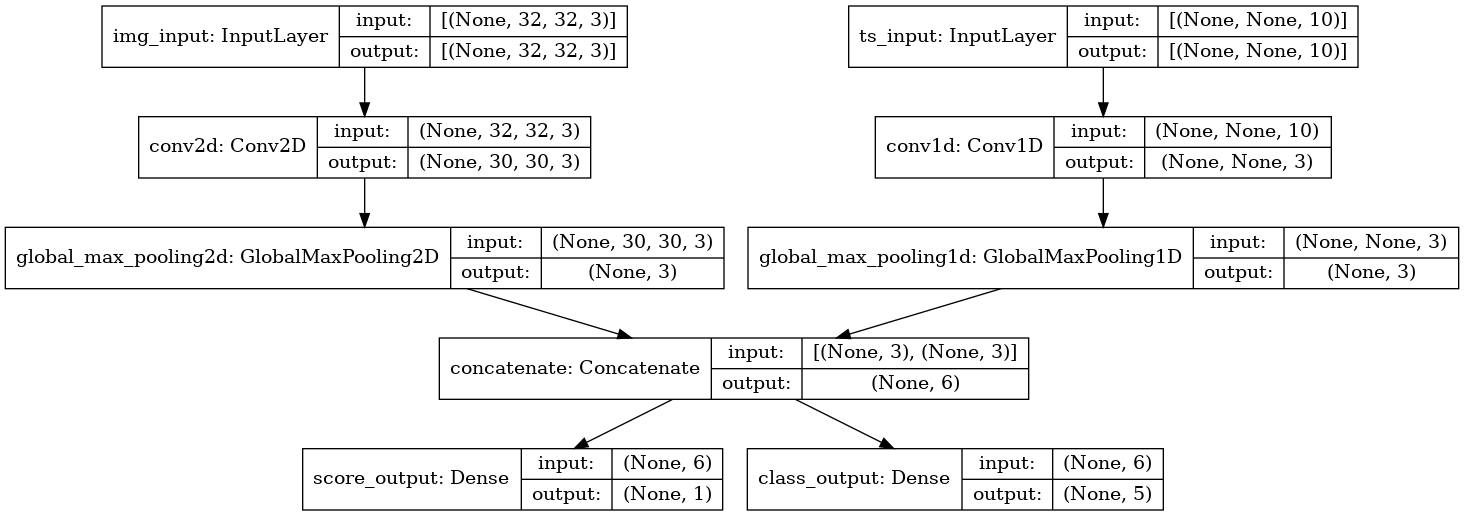

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

At compilation time, we can specify different losses to different outputs, by passing
the loss functions as a list:

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

If we only passed a single loss function to the model, the same loss function would be
applied to every output (which is not appropriate here).

Likewise for metrics:

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

Since we gave names to our output layers, we could also specify per-output losses and
metrics via a dict:

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

We recommend the use of explicit names and dicts if you have more than 2 outputs.

It's possible to give different weights to different output-specific losses (for
instance, one might wish to privilege the "score" loss in our example, by giving to 2x
the importance of the class loss), using the `loss_weights` argument:

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

You could also choose not to compute a loss for certain outputs, if these outputs are
meant for prediction but not for training:

In [34]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

Passing data to a multi-input or multi-output model in `fit()` works in a similar way as
specifying a loss function in compile: you can pass **lists of NumPy arrays** (with
1:1 mapping to the outputs that received a loss function) or **dicts mapping output
names to NumPy arrays**.

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

1/4 [======>.......................] - ETA: 30s - loss: 13.6661 - score_output_loss: 0.8359 - class_output_loss: 12.8301

4/4 [==============================] - 10s 10ms/step - loss: 12.4255 - score_output_loss: 0.7638 - class_output_loss: 11.6617


1/4 [======>.......................] - ETA: 1s - loss: 11.0760 - score_output_loss: 0.7422 - class_output_loss: 10.3339

4/4 [==============================] - 0s 5ms/step - loss: 11.1176 - score_output_loss: 0.6303 - class_output_loss: 10.4873


Here's the `Dataset` use case: similarly as what we did for NumPy arrays, the `Dataset`
should return a tuple of dicts.

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

1/2 [==============>...............] - ETA: 0s - loss: 11.2991 - score_output_loss: 0.5282 - class_output_loss: 10.7709

2/2 [==============================] - 0s 27ms/step - loss: 10.9011 - score_output_loss: 0.4919 - class_output_loss: 10.4092


## Using callbacks

Callbacks in Keras are objects that are called at different points during training (at
the start of an epoch, at the end of a batch, at the end of an epoch, etc.). They
can be used to implement certain behaviors, such as:

- Doing validation at different points during training (beyond the built-in per-epoch
validation)
- Checkpointing the model at regular intervals or when it exceeds a certain accuracy
threshold
- Changing the learning rate of the model when training seems to be plateauing
- Doing fine-tuning of the top layers when training seems to be plateauing
- Sending email or instant message notifications when training ends or where a certain
performance threshold is exceeded
- Etc.

Callbacks can be passed as a list to your call to `fit()`:

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20


  1/625 [..............................] - ETA: 3:13 - loss: 2.3283 - sparse_categorical_accuracy: 0.0625

 30/625 [>.............................] - ETA: 1s - loss: 1.7546 - sparse_categorical_accuracy: 0.4815  

 58/625 [=>............................] - ETA: 1s - loss: 1.4757 - sparse_categorical_accuracy: 0.5873

 87/625 [===>..........................] - ETA: 0s - loss: 1.2964 - sparse_categorical_accuracy: 0.6443

116/625 [====>.........................] - ETA: 0s - loss: 1.1720 - sparse_categorical_accuracy: 0.6810

145/625 [=====>........................] - ETA: 0s - loss: 1.0796 - sparse_categorical_accuracy: 0.7073

173/625 [=======>......................] - ETA: 0s - loss: 1.0095 - sparse_categorical_accuracy: 0.7268

201/625 [========>.....................] - ETA: 0s - loss: 0.9521 - sparse_categorical_accuracy: 0.7426

229/625 [=========>....................] - ETA: 0s - loss: 0.9042 - sparse_categorical_accuracy: 0.7557

257/625 [===========>..................] - ETA: 0s - loss: 0.8636 - sparse_categorical_accuracy: 0.7667

286/625 [============>.................] - ETA: 0s - loss: 0.8275 - sparse_categorical_accuracy: 0.7764

315/625 [==============>...............] - ETA: 0s - loss: 0.7963 - sparse_categorical_accuracy: 0.7847

344/625 [===============>..............] - ETA: 0s - loss: 0.7691 - sparse_categorical_accuracy: 0.7920

373/625 [================>.............] - ETA: 0s - loss: 0.7450 - sparse_categorical_accuracy: 0.7985

402/625 [==================>...........] - ETA: 0s - loss: 0.7234 - sparse_categorical_accuracy: 0.8043

430/625 [===================>..........] - ETA: 0s - loss: 0.7045 - sparse_categorical_accuracy: 0.8093

456/625 [====================>.........] - ETA: 0s - loss: 0.6884 - sparse_categorical_accuracy: 0.8136

483/625 [======================>.......] - ETA: 0s - loss: 0.6730 - sparse_categorical_accuracy: 0.8178

511/625 [=======================>......] - ETA: 0s - loss: 0.6582 - sparse_categorical_accuracy: 0.8217

540/625 [========================>.....] - ETA: 0s - loss: 0.6440 - sparse_categorical_accuracy: 0.8254

568/625 [==========================>...] - ETA: 0s - loss: 0.6313 - sparse_categorical_accuracy: 0.8288

596/625 [===========================>..] - ETA: 0s - loss: 0.6195 - sparse_categorical_accuracy: 0.8319

625/625 [==============================] - ETA: 0s - loss: 0.6080 - sparse_categorical_accuracy: 0.8349

625/625 [==============================] - 2s 3ms/step - loss: 0.6076 - sparse_categorical_accuracy: 0.8350 - val_loss: 0.2323 - val_sparse_categorical_accuracy: 0.9306


Epoch 2/20
  1/625 [..............................] - ETA: 1s - loss: 0.1709 - sparse_categorical_accuracy: 0.9375

 29/625 [>.............................] - ETA: 1s - loss: 0.2175 - sparse_categorical_accuracy: 0.9408

 58/625 [=>............................] - ETA: 1s - loss: 0.2161 - sparse_categorical_accuracy: 0.9396

 86/625 [===>..........................] - ETA: 0s - loss: 0.2152 - sparse_categorical_accuracy: 0.9395

115/625 [====>.........................] - ETA: 0s - loss: 0.2137 - sparse_categorical_accuracy: 0.9397

144/625 [=====>........................] - ETA: 0s - loss: 0.2118 - sparse_categorical_accuracy: 0.9399

172/625 [=======>......................] - ETA: 0s - loss: 0.2104 - sparse_categorical_accuracy: 0.9400

200/625 [========>.....................] - ETA: 0s - loss: 0.2090 - sparse_categorical_accuracy: 0.9402

229/625 [=========>....................] - ETA: 0s - loss: 0.2076 - sparse_categorical_accuracy: 0.9404

258/625 [===========>..................] - ETA: 0s - loss: 0.2063 - sparse_categorical_accuracy: 0.9406

287/625 [============>.................] - ETA: 0s - loss: 0.2049 - sparse_categorical_accuracy: 0.9409

316/625 [==============>...............] - ETA: 0s - loss: 0.2034 - sparse_categorical_accuracy: 0.9412

345/625 [===============>..............] - ETA: 0s - loss: 0.2021 - sparse_categorical_accuracy: 0.9415

374/625 [================>.............] - ETA: 0s - loss: 0.2008 - sparse_categorical_accuracy: 0.9417

402/625 [==================>...........] - ETA: 0s - loss: 0.1996 - sparse_categorical_accuracy: 0.9420

431/625 [===================>..........] - ETA: 0s - loss: 0.1986 - sparse_categorical_accuracy: 0.9422

460/625 [=====================>........] - ETA: 0s - loss: 0.1976 - sparse_categorical_accuracy: 0.9424

489/625 [======================>.......] - ETA: 0s - loss: 0.1967 - sparse_categorical_accuracy: 0.9426

518/625 [=======================>......] - ETA: 0s - loss: 0.1957 - sparse_categorical_accuracy: 0.9428

547/625 [=========================>....] - ETA: 0s - loss: 0.1948 - sparse_categorical_accuracy: 0.9431

576/625 [==========================>...] - ETA: 0s - loss: 0.1940 - sparse_categorical_accuracy: 0.9433

605/625 [============================>.] - ETA: 0s - loss: 0.1931 - sparse_categorical_accuracy: 0.9435

625/625 [==============================] - 1s 2ms/step - loss: 0.1925 - sparse_categorical_accuracy: 0.9436 - val_loss: 0.1828 - val_sparse_categorical_accuracy: 0.9446


Epoch 3/20
  1/625 [..............................] - ETA: 1s - loss: 0.1839 - sparse_categorical_accuracy: 0.9375

 30/625 [>.............................] - ETA: 1s - loss: 0.1295 - sparse_categorical_accuracy: 0.9638

 59/625 [=>............................] - ETA: 0s - loss: 0.1294 - sparse_categorical_accuracy: 0.9640

 88/625 [===>..........................] - ETA: 0s - loss: 0.1290 - sparse_categorical_accuracy: 0.9637

117/625 [====>.........................] - ETA: 0s - loss: 0.1293 - sparse_categorical_accuracy: 0.9633

146/625 [======>.......................] - ETA: 0s - loss: 0.1300 - sparse_categorical_accuracy: 0.9628

175/625 [=======>......................] - ETA: 0s - loss: 0.1303 - sparse_categorical_accuracy: 0.9626

203/625 [========>.....................] - ETA: 0s - loss: 0.1308 - sparse_categorical_accuracy: 0.9623

231/625 [==========>...................] - ETA: 0s - loss: 0.1310 - sparse_categorical_accuracy: 0.9622

260/625 [===========>..................] - ETA: 0s - loss: 0.1312 - sparse_categorical_accuracy: 0.9620

289/625 [============>.................] - ETA: 0s - loss: 0.1314 - sparse_categorical_accuracy: 0.9619

316/625 [==============>...............] - ETA: 0s - loss: 0.1314 - sparse_categorical_accuracy: 0.9618

344/625 [===============>..............] - ETA: 0s - loss: 0.1314 - sparse_categorical_accuracy: 0.9618

370/625 [================>.............] - ETA: 0s - loss: 0.1315 - sparse_categorical_accuracy: 0.9617

396/625 [==================>...........] - ETA: 0s - loss: 0.1316 - sparse_categorical_accuracy: 0.9616

423/625 [===================>..........] - ETA: 0s - loss: 0.1317 - sparse_categorical_accuracy: 0.9616

449/625 [====================>.........] - ETA: 0s - loss: 0.1318 - sparse_categorical_accuracy: 0.9615

476/625 [=====================>........] - ETA: 0s - loss: 0.1318 - sparse_categorical_accuracy: 0.9615

503/625 [=======================>......] - ETA: 0s - loss: 0.1318 - sparse_categorical_accuracy: 0.9615

530/625 [========================>.....] - ETA: 0s - loss: 0.1317 - sparse_categorical_accuracy: 0.9615

557/625 [=========================>....] - ETA: 0s - loss: 0.1315 - sparse_categorical_accuracy: 0.9615

584/625 [===========================>..] - ETA: 0s - loss: 0.1313 - sparse_categorical_accuracy: 0.9616

611/625 [============================>.] - ETA: 0s - loss: 0.1311 - sparse_categorical_accuracy: 0.9616

625/625 [==============================] - 1s 2ms/step - loss: 0.1310 - sparse_categorical_accuracy: 0.9616 - val_loss: 0.1580 - val_sparse_categorical_accuracy: 0.9510


Epoch 4/20
  1/625 [..............................] - ETA: 1s - loss: 0.0546 - sparse_categorical_accuracy: 0.9844

 29/625 [>.............................] - ETA: 1s - loss: 0.0636 - sparse_categorical_accuracy: 0.9813

 57/625 [=>............................] - ETA: 1s - loss: 0.0741 - sparse_categorical_accuracy: 0.9765

 85/625 [===>..........................] - ETA: 0s - loss: 0.0800 - sparse_categorical_accuracy: 0.9740

114/625 [====>.........................] - ETA: 0s - loss: 0.0838 - sparse_categorical_accuracy: 0.9726

142/625 [=====>........................] - ETA: 0s - loss: 0.0861 - sparse_categorical_accuracy: 0.9720

170/625 [=======>......................] - ETA: 0s - loss: 0.0880 - sparse_categorical_accuracy: 0.9717

198/625 [========>.....................] - ETA: 0s - loss: 0.0898 - sparse_categorical_accuracy: 0.9714

225/625 [=========>....................] - ETA: 0s - loss: 0.0911 - sparse_categorical_accuracy: 0.9711

250/625 [===========>..................] - ETA: 0s - loss: 0.0919 - sparse_categorical_accuracy: 0.9710

277/625 [============>.................] - ETA: 0s - loss: 0.0927 - sparse_categorical_accuracy: 0.9708

305/625 [=============>................] - ETA: 0s - loss: 0.0935 - sparse_categorical_accuracy: 0.9706

334/625 [===============>..............] - ETA: 0s - loss: 0.0941 - sparse_categorical_accuracy: 0.9705

363/625 [================>.............] - ETA: 0s - loss: 0.0946 - sparse_categorical_accuracy: 0.9704

392/625 [=================>............] - ETA: 0s - loss: 0.0950 - sparse_categorical_accuracy: 0.9703

421/625 [===================>..........] - ETA: 0s - loss: 0.0953 - sparse_categorical_accuracy: 0.9702

450/625 [====================>.........] - ETA: 0s - loss: 0.0955 - sparse_categorical_accuracy: 0.9702

479/625 [=====================>........] - ETA: 0s - loss: 0.0957 - sparse_categorical_accuracy: 0.9701

508/625 [=======================>......] - ETA: 0s - loss: 0.0959 - sparse_categorical_accuracy: 0.9701

537/625 [========================>.....] - ETA: 0s - loss: 0.0961 - sparse_categorical_accuracy: 0.9701

566/625 [==========================>...] - ETA: 0s - loss: 0.0962 - sparse_categorical_accuracy: 0.9700

595/625 [===========================>..] - ETA: 0s - loss: 0.0964 - sparse_categorical_accuracy: 0.9700

624/625 [============================>.] - ETA: 0s - loss: 0.0967 - sparse_categorical_accuracy: 0.9700

625/625 [==============================] - 1s 2ms/step - loss: 0.0967 - sparse_categorical_accuracy: 0.9700 - val_loss: 0.1681 - val_sparse_categorical_accuracy: 0.9490


Epoch 5/20
  1/625 [..............................] - ETA: 1s - loss: 0.0546 - sparse_categorical_accuracy: 0.9844

 30/625 [>.............................] - ETA: 1s - loss: 0.0823 - sparse_categorical_accuracy: 0.9742

 59/625 [=>............................] - ETA: 0s - loss: 0.0866 - sparse_categorical_accuracy: 0.9728

 88/625 [===>..........................] - ETA: 0s - loss: 0.0880 - sparse_categorical_accuracy: 0.9723

117/625 [====>.........................] - ETA: 0s - loss: 0.0886 - sparse_categorical_accuracy: 0.9722

146/625 [======>.......................] - ETA: 0s - loss: 0.0884 - sparse_categorical_accuracy: 0.9725

175/625 [=======>......................] - ETA: 0s - loss: 0.0881 - sparse_categorical_accuracy: 0.9726

204/625 [========>.....................] - ETA: 0s - loss: 0.0876 - sparse_categorical_accuracy: 0.9728

233/625 [==========>...................] - ETA: 0s - loss: 0.0872 - sparse_categorical_accuracy: 0.9730

262/625 [===========>..................] - ETA: 0s - loss: 0.0868 - sparse_categorical_accuracy: 0.9731

291/625 [============>.................] - ETA: 0s - loss: 0.0864 - sparse_categorical_accuracy: 0.9733

320/625 [==============>...............] - ETA: 0s - loss: 0.0860 - sparse_categorical_accuracy: 0.9734

348/625 [===============>..............] - ETA: 0s - loss: 0.0857 - sparse_categorical_accuracy: 0.9735

378/625 [=================>............] - ETA: 0s - loss: 0.0853 - sparse_categorical_accuracy: 0.9736

407/625 [==================>...........] - ETA: 0s - loss: 0.0850 - sparse_categorical_accuracy: 0.9738

436/625 [===================>..........] - ETA: 0s - loss: 0.0847 - sparse_categorical_accuracy: 0.9739

465/625 [=====================>........] - ETA: 0s - loss: 0.0846 - sparse_categorical_accuracy: 0.9739

494/625 [======================>.......] - ETA: 0s - loss: 0.0845 - sparse_categorical_accuracy: 0.9739

523/625 [========================>.....] - ETA: 0s - loss: 0.0845 - sparse_categorical_accuracy: 0.9740

552/625 [=========================>....] - ETA: 0s - loss: 0.0844 - sparse_categorical_accuracy: 0.9740

581/625 [==========================>...] - ETA: 0s - loss: 0.0843 - sparse_categorical_accuracy: 0.9741

610/625 [============================>.] - ETA: 0s - loss: 0.0842 - sparse_categorical_accuracy: 0.9741

625/625 [==============================] - 1s 2ms/step - loss: 0.0841 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.1482 - val_sparse_categorical_accuracy: 0.9568


Epoch 00005: early stopping


### Many built-in callbacks are available

There are many built-in callbacks already available in Keras, such as:

- `ModelCheckpoint`: Periodically save the model.
- `EarlyStopping`: Stop training when training is no longer improving the validation
metrics.
- `TensorBoard`: periodically write model logs that can be visualized in
[TensorBoard](https://www.tensorflow.org/tensorboard) (more details in the section
"Visualization").
- `CSVLogger`: streams loss and metrics data to a CSV file.
- etc.

See the [callbacks documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/) for the complete list.

### Writing your own callback

You can create a custom callback by extending the base class
`keras.callbacks.Callback`. A callback has access to its associated model through the
class property `self.model`.

Make sure to read the
[complete guide to writing custom callbacks](https://www.tensorflow.org/guide/keras/custom_callback/).

Here's a simple example saving a list of per-batch loss values during training:

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## Checkpointing models

When you're training model on relatively large datasets, it's crucial to save
checkpoints of your model at frequent intervals.

The easiest way to achieve this is with the `ModelCheckpoint` callback:

In [39]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2


  1/625 [..............................] - ETA: 3:14 - loss: 2.3913 - sparse_categorical_accuracy: 0.0469

 30/625 [>.............................] - ETA: 1s - loss: 1.8384 - sparse_categorical_accuracy: 0.4440  

 59/625 [=>............................] - ETA: 1s - loss: 1.5463 - sparse_categorical_accuracy: 0.5522

 88/625 [===>..........................] - ETA: 0s - loss: 1.3607 - sparse_categorical_accuracy: 0.6130

117/625 [====>.........................] - ETA: 0s - loss: 1.2321 - sparse_categorical_accuracy: 0.6529

146/625 [======>.......................] - ETA: 0s - loss: 1.1362 - sparse_categorical_accuracy: 0.6819

175/625 [=======>......................] - ETA: 0s - loss: 1.0615 - sparse_categorical_accuracy: 0.7037

204/625 [========>.....................] - ETA: 0s - loss: 1.0013 - sparse_categorical_accuracy: 0.7210

232/625 [==========>...................] - ETA: 0s - loss: 0.9527 - sparse_categorical_accuracy: 0.7347

261/625 [===========>..................] - ETA: 0s - loss: 0.9097 - sparse_categorical_accuracy: 0.7467

290/625 [============>.................] - ETA: 0s - loss: 0.8724 - sparse_categorical_accuracy: 0.7571

319/625 [==============>...............] - ETA: 0s - loss: 0.8398 - sparse_categorical_accuracy: 0.7661

349/625 [===============>..............] - ETA: 0s - loss: 0.8101 - sparse_categorical_accuracy: 0.7743

378/625 [=================>............] - ETA: 0s - loss: 0.7845 - sparse_categorical_accuracy: 0.7813

407/625 [==================>...........] - ETA: 0s - loss: 0.7616 - sparse_categorical_accuracy: 0.7877

436/625 [===================>..........] - ETA: 0s - loss: 0.7407 - sparse_categorical_accuracy: 0.7934

465/625 [=====================>........] - ETA: 0s - loss: 0.7217 - sparse_categorical_accuracy: 0.7986

494/625 [======================>.......] - ETA: 0s - loss: 0.7043 - sparse_categorical_accuracy: 0.8034

523/625 [========================>.....] - ETA: 0s - loss: 0.6882 - sparse_categorical_accuracy: 0.8078

552/625 [=========================>....] - ETA: 0s - loss: 0.6733 - sparse_categorical_accuracy: 0.8118

581/625 [==========================>...] - ETA: 0s - loss: 0.6595 - sparse_categorical_accuracy: 0.8156

610/625 [============================>.] - ETA: 0s - loss: 0.6465 - sparse_categorical_accuracy: 0.8192

625/625 [==============================] - 2s 2ms/step - loss: 0.6397 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.2310 - val_sparse_categorical_accuracy: 0.9326



Epoch 00001: val_loss improved from inf to 0.23098, saving model to mymodel_1


INFO:tensorflow:Assets written to: mymodel_1/assets


Epoch 2/2
  1/625 [..............................] - ETA: 2s - loss: 0.1137 - sparse_categorical_accuracy: 0.9844

 30/625 [>.............................] - ETA: 1s - loss: 0.1887 - sparse_categorical_accuracy: 0.9549

 60/625 [=>............................] - ETA: 0s - loss: 0.1921 - sparse_categorical_accuracy: 0.9511

 89/625 [===>..........................] - ETA: 0s - loss: 0.1943 - sparse_categorical_accuracy: 0.9482

118/625 [====>.........................] - ETA: 0s - loss: 0.1938 - sparse_categorical_accuracy: 0.9470

147/625 [======>.......................] - ETA: 0s - loss: 0.1928 - sparse_categorical_accuracy: 0.9464

176/625 [=======>......................] - ETA: 0s - loss: 0.1919 - sparse_categorical_accuracy: 0.9462

205/625 [========>.....................] - ETA: 0s - loss: 0.1915 - sparse_categorical_accuracy: 0.9460

234/625 [==========>...................] - ETA: 0s - loss: 0.1913 - sparse_categorical_accuracy: 0.9457

263/625 [===========>..................] - ETA: 0s - loss: 0.1912 - sparse_categorical_accuracy: 0.9456

292/625 [=============>................] - ETA: 0s - loss: 0.1912 - sparse_categorical_accuracy: 0.9454

321/625 [==============>...............] - ETA: 0s - loss: 0.1910 - sparse_categorical_accuracy: 0.9453

350/625 [===============>..............] - ETA: 0s - loss: 0.1909 - sparse_categorical_accuracy: 0.9452

380/625 [=================>............] - ETA: 0s - loss: 0.1908 - sparse_categorical_accuracy: 0.9452

409/625 [==================>...........] - ETA: 0s - loss: 0.1907 - sparse_categorical_accuracy: 0.9451

438/625 [====================>.........] - ETA: 0s - loss: 0.1905 - sparse_categorical_accuracy: 0.9451

467/625 [=====================>........] - ETA: 0s - loss: 0.1902 - sparse_categorical_accuracy: 0.9452

496/625 [======================>.......] - ETA: 0s - loss: 0.1899 - sparse_categorical_accuracy: 0.9452

525/625 [========================>.....] - ETA: 0s - loss: 0.1896 - sparse_categorical_accuracy: 0.9452

554/625 [=========================>....] - ETA: 0s - loss: 0.1893 - sparse_categorical_accuracy: 0.9453

583/625 [==========================>...] - ETA: 0s - loss: 0.1890 - sparse_categorical_accuracy: 0.9453

612/625 [============================>.] - ETA: 0s - loss: 0.1887 - sparse_categorical_accuracy: 0.9454

625/625 [==============================] - 1s 2ms/step - loss: 0.1885 - sparse_categorical_accuracy: 0.9454 - val_loss: 0.1851 - val_sparse_categorical_accuracy: 0.9435



Epoch 00002: val_loss improved from 0.23098 to 0.18510, saving model to mymodel_2


INFO:tensorflow:Assets written to: mymodel_2/assets


The `ModelCheckpoint` callback can be used to implement fault-tolerance:
the ability to restart training from the last saved state of the model in case training
gets randomly interrupted. Here's a basic example:

In [40]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model


   1/1563 [..............................] - ETA: 8:07 - loss: 2.3160 - sparse_categorical_accuracy: 0.1250

  29/1563 [..............................] - ETA: 2s - loss: 1.8967 - sparse_categorical_accuracy: 0.3917  

  57/1563 [>.............................] - ETA: 2s - loss: 1.6257 - sparse_categorical_accuracy: 0.5070

  85/1563 [>.............................] - ETA: 2s - loss: 1.4465 - sparse_categorical_accuracy: 0.5717

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.93/assets


 101/1563 [>.............................] - ETA: 7s - loss: 1.3690 - sparse_categorical_accuracy: 0.5979

 129/1563 [=>............................] - ETA: 6s - loss: 1.2609 - sparse_categorical_accuracy: 0.6328

 157/1563 [==>...........................] - ETA: 5s - loss: 1.1784 - sparse_categorical_accuracy: 0.6583

 185/1563 [==>...........................] - ETA: 5s - loss: 1.1118 - sparse_categorical_accuracy: 0.6784

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.69/assets


 201/1563 [==>...........................] - ETA: 7s - loss: 1.0792 - sparse_categorical_accuracy: 0.6882

 228/1563 [===>..........................] - ETA: 6s - loss: 1.0307 - sparse_categorical_accuracy: 0.7026

 256/1563 [===>..........................] - ETA: 6s - loss: 0.9872 - sparse_categorical_accuracy: 0.7155

 284/1563 [====>.........................] - ETA: 5s - loss: 0.9495 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.58/assets


 301/1563 [====>.........................] - ETA: 6s - loss: 0.9291 - sparse_categorical_accuracy: 0.7326

 329/1563 [=====>........................] - ETA: 6s - loss: 0.8985 - sparse_categorical_accuracy: 0.7417

 357/1563 [=====>........................] - ETA: 5s - loss: 0.8711 - sparse_categorical_accuracy: 0.7497

 385/1563 [======>.......................] - ETA: 5s - loss: 0.8464 - sparse_categorical_accuracy: 0.7569

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.52/assets


 401/1563 [======>.......................] - ETA: 6s - loss: 0.8334 - sparse_categorical_accuracy: 0.7607

 429/1563 [=======>......................] - ETA: 5s - loss: 0.8121 - sparse_categorical_accuracy: 0.7668

 457/1563 [=======>......................] - ETA: 5s - loss: 0.7927 - sparse_categorical_accuracy: 0.7725

 485/1563 [========>.....................] - ETA: 5s - loss: 0.7749 - sparse_categorical_accuracy: 0.7776

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.47/assets


 501/1563 [========>.....................] - ETA: 5s - loss: 0.7653 - sparse_categorical_accuracy: 0.7803

 529/1563 [=========>....................] - ETA: 5s - loss: 0.7495 - sparse_categorical_accuracy: 0.7849

 557/1563 [=========>....................] - ETA: 5s - loss: 0.7347 - sparse_categorical_accuracy: 0.7891

 585/1563 [==========>...................] - ETA: 4s - loss: 0.7210 - sparse_categorical_accuracy: 0.7930

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.44/assets


 601/1563 [==========>...................] - ETA: 5s - loss: 0.7136 - sparse_categorical_accuracy: 0.7951

 629/1563 [===========>..................] - ETA: 5s - loss: 0.7012 - sparse_categorical_accuracy: 0.7986

 657/1563 [===========>..................] - ETA: 4s - loss: 0.6897 - sparse_categorical_accuracy: 0.8019

 685/1563 [============>.................] - ETA: 4s - loss: 0.6788 - sparse_categorical_accuracy: 0.8050

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.42/assets


 701/1563 [============>.................] - ETA: 4s - loss: 0.6729 - sparse_categorical_accuracy: 0.8067

 729/1563 [============>.................] - ETA: 4s - loss: 0.6629 - sparse_categorical_accuracy: 0.8096

 757/1563 [=============>................] - ETA: 4s - loss: 0.6535 - sparse_categorical_accuracy: 0.8123

 785/1563 [==============>...............] - ETA: 4s - loss: 0.6445 - sparse_categorical_accuracy: 0.8149

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.40/assets


 801/1563 [==============>...............] - ETA: 4s - loss: 0.6396 - sparse_categorical_accuracy: 0.8163

 829/1563 [==============>...............] - ETA: 3s - loss: 0.6314 - sparse_categorical_accuracy: 0.8186

 857/1563 [===============>..............] - ETA: 3s - loss: 0.6235 - sparse_categorical_accuracy: 0.8209

 883/1563 [===============>..............] - ETA: 3s - loss: 0.6165 - sparse_categorical_accuracy: 0.8229

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.38/assets


 901/1563 [================>.............] - ETA: 3s - loss: 0.6118 - sparse_categorical_accuracy: 0.8242

 928/1563 [================>.............] - ETA: 3s - loss: 0.6049 - sparse_categorical_accuracy: 0.8262

 956/1563 [=================>............] - ETA: 3s - loss: 0.5982 - sparse_categorical_accuracy: 0.8281

 984/1563 [=================>............] - ETA: 3s - loss: 0.5917 - sparse_categorical_accuracy: 0.8299

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.37/assets


1001/1563 [==================>...........] - ETA: 3s - loss: 0.5879 - sparse_categorical_accuracy: 0.8310

1027/1563 [==================>...........] - ETA: 2s - loss: 0.5822 - sparse_categorical_accuracy: 0.8326

1054/1563 [===================>..........] - ETA: 2s - loss: 0.5766 - sparse_categorical_accuracy: 0.8342

1082/1563 [===================>..........] - ETA: 2s - loss: 0.5709 - sparse_categorical_accuracy: 0.8358

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.35/assets


1101/1563 [====================>.........] - ETA: 2s - loss: 0.5672 - sparse_categorical_accuracy: 0.8369

1129/1563 [====================>.........] - ETA: 2s - loss: 0.5619 - sparse_categorical_accuracy: 0.8384

1157/1563 [=====================>........] - ETA: 2s - loss: 0.5567 - sparse_categorical_accuracy: 0.8399

1185/1563 [=====================>........] - ETA: 1s - loss: 0.5517 - sparse_categorical_accuracy: 0.8413

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.34/assets


1201/1563 [======================>.......] - ETA: 1s - loss: 0.5489 - sparse_categorical_accuracy: 0.8421

1227/1563 [======================>.......] - ETA: 1s - loss: 0.5445 - sparse_categorical_accuracy: 0.8434

1254/1563 [=======================>......] - ETA: 1s - loss: 0.5401 - sparse_categorical_accuracy: 0.8446

1282/1563 [=======================>......] - ETA: 1s - loss: 0.5356 - sparse_categorical_accuracy: 0.8459

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.33/assets


1301/1563 [=======================>......] - ETA: 1s - loss: 0.5326 - sparse_categorical_accuracy: 0.8468

1328/1563 [========================>.....] - ETA: 1s - loss: 0.5285 - sparse_categorical_accuracy: 0.8479

1356/1563 [=========================>....] - ETA: 1s - loss: 0.5243 - sparse_categorical_accuracy: 0.8491

1384/1563 [=========================>....] - ETA: 0s - loss: 0.5202 - sparse_categorical_accuracy: 0.8503

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.32/assets


1401/1563 [=========================>....] - ETA: 0s - loss: 0.5178 - sparse_categorical_accuracy: 0.8510

1428/1563 [==========================>...] - ETA: 0s - loss: 0.5140 - sparse_categorical_accuracy: 0.8521

1456/1563 [==========================>...] - ETA: 0s - loss: 0.5102 - sparse_categorical_accuracy: 0.8531

1484/1563 [===========================>..] - ETA: 0s - loss: 0.5065 - sparse_categorical_accuracy: 0.8542

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.31/assets


1501/1563 [===========================>..] - ETA: 0s - loss: 0.5043 - sparse_categorical_accuracy: 0.8548

1529/1563 [============================>.] - ETA: 0s - loss: 0.5008 - sparse_categorical_accuracy: 0.8558

1557/1563 [============================>.] - ETA: 0s - loss: 0.4973 - sparse_categorical_accuracy: 0.8568

1563/1563 [==============================] - 9s 5ms/step - loss: 0.4965 - sparse_categorical_accuracy: 0.8570


You call also write your own callback for saving and restoring models.

For a complete guide on serialization and saving, see the
[guide to saving and serializing Models](https://www.tensorflow.org/guide/keras/save_and_serialize/).

## Using learning rate schedules

A common pattern when training deep learning models is to gradually reduce the learning
as training progresses. This is generally known as "learning rate decay".

The learning decay schedule could be static (fixed in advance, as a function of the
current epoch or the current batch index), or dynamic (responding to the current
behavior of the model, in particular the validation loss).

### Passing a schedule to an optimizer

You can easily use a static learning rate decay schedule by passing a schedule object
as the `learning_rate` argument in your optimizer:

In [41]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

Several built-in schedules are available: `ExponentialDecay`, `PiecewiseConstantDecay`,
`PolynomialDecay`, and `InverseTimeDecay`.

### Using callbacks to implement a dynamic learning rate schedule

A dynamic learning rate schedule (for instance, decreasing the learning rate when the
validation loss is no longer improving) cannot be achieved with these schedule objects,
since the optimizer does not have access to validation metrics.

However, callbacks do have access to all metrics, including validation metrics! You can
thus achieve this pattern by using a callback that modifies the current learning rate
on the optimizer. In fact, this is even built-in as the `ReduceLROnPlateau` callback.

## Visualizing loss and metrics during training

The best way to keep an eye on your model during training is to use
[TensorBoard](https://www.tensorflow.org/tensorboard) -- a browser-based application
that you can run locally that provides you with:

- Live plots of the loss and metrics for training and evaluation
- (optionally) Visualizations of the histograms of your layer activations
- (optionally) 3D visualizations of the embedding spaces learned by your `Embedding`
layers

If you have installed TensorFlow with pip, you should be able to launch TensorBoard
from the command line:

```
tensorboard --logdir=/full_path_to_your_logs
```

### Using the TensorBoard callback

The easiest way to use TensorBoard with a Keras model and the `fit()` method is the
`TensorBoard` callback.

In the simplest case, just specify where you want the callback to write logs, and
you're good to go:

In [42]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

For more information, see the
[documentation for the `TensorBoard` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/).